<a href="https://colab.research.google.com/github/Safaa860/BrainTumorsegmentationUnet/blob/main/HGG_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install SimpleITK

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 35.4 MB/s eta 0:00:00


In [2]:
#importing libraries
import os
import matplotlib.pyplot as plt
import SimpleITK as sitk
import numpy as np
import glob  # For populating the list of files
from tqdm import tqdm


from keras.models import Model
from keras.layers import MaxPooling2D,Conv2D,Dense,BatchNormalization,concatenate,Input,Dropout,Maximum,Activation,Dense,Flatten,UpSampling2D,Conv2DTranspose
from keras.optimizers import SGD,Adam,RMSprop
import keras.callbacks as callbacks
import keras.initializers as initializers
from keras.callbacks import Callback
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical,normalize


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!unzip /content/drive/MyDrive/MICCAI_BraTS_2018_Data_Training.zip -d /content/dataset

Archive:  /content/drive/MyDrive/MICCAI_BraTS_2018_Data_Training.zip
   creating: /content/dataset/HGG/
   creating: /content/dataset/HGG/Brats18_2013_10_1/
  inflating: /content/dataset/HGG/Brats18_2013_10_1/Brats18_2013_10_1_flair.nii.gz  
  inflating: /content/dataset/HGG/Brats18_2013_10_1/Brats18_2013_10_1_seg.nii.gz  
  inflating: /content/dataset/HGG/Brats18_2013_10_1/Brats18_2013_10_1_t1.nii.gz  
  inflating: /content/dataset/HGG/Brats18_2013_10_1/Brats18_2013_10_1_t1ce.nii.gz  
  inflating: /content/dataset/HGG/Brats18_2013_10_1/Brats18_2013_10_1_t2.nii.gz  
   creating: /content/dataset/HGG/Brats18_2013_11_1/
  inflating: /content/dataset/HGG/Brats18_2013_11_1/Brats18_2013_11_1_flair.nii.gz  
  inflating: /content/dataset/HGG/Brats18_2013_11_1/Brats18_2013_11_1_seg.nii.gz  
  inflating: /content/dataset/HGG/Brats18_2013_11_1/Brats18_2013_11_1_t1.nii.gz  
  inflating: /content/dataset/HGG/Brats18_2013_11_1/Brats18_2013_11_1_t1ce.nii.gz  
  inflating: /content/dataset/HGG/Brats1

In [5]:
#Extract path of folders
path1 = '/content/dataset/HGG'
path2 = '/content/dataset/LGG'

In [7]:
def loading_dataset(path):
  my_dir = sorted(os.listdir(path)[:175])
  print("main dir length", len(my_dir))
  dataset = []
  labels = []
  for p in tqdm(my_dir):
    data_list = sorted(os.listdir(path+'/'+p))
    print('total length', len(data_list))
    print("datalist", data_list)
    img_itk = sitk.ReadImage(path + '/' + p + '/'+ data_list[0])
    flair = sitk.GetArrayFromImage(img_itk)
    img_itk = sitk.ReadImage(path + '/' + p + '/'+ data_list[1])
    seg =  sitk.GetArrayFromImage(img_itk)
    img_itk = sitk.ReadImage(path + '/' + p + '/'+ data_list[2])
    t1 =  sitk.GetArrayFromImage(img_itk)
    img_itk = sitk.ReadImage(path + '/' + p + '/'+ data_list[3])
    t1ce =  sitk.GetArrayFromImage(img_itk)
    img_itk = sitk.ReadImage(path +'/' + p + '/'+ data_list[4])
    t2 =  sitk.GetArrayFromImage(img_itk)
    dataset.append([flair,t1,t1ce,t2]) #Appending images in array
    labels.append(seg) #Appending Label in array
  dataset = np.asarray(dataset,dtype=np.float32)
  labels = np.asarray(labels,dtype=np.uint8)
  return dataset,labels

In [8]:
hgg_data, hgg_label = loading_dataset(path1)

main dir length 175


  0%|          | 0/175 [00:00<?, ?it/s]

total length 5
datalist ['Brats18_2013_10_1_flair.nii.gz', 'Brats18_2013_10_1_seg.nii.gz', 'Brats18_2013_10_1_t1.nii.gz', 'Brats18_2013_10_1_t1ce.nii.gz', 'Brats18_2013_10_1_t2.nii.gz']


  1%|          | 1/175 [00:00<00:34,  5.05it/s]

total length 5
datalist ['Brats18_2013_11_1_flair.nii.gz', 'Brats18_2013_11_1_seg.nii.gz', 'Brats18_2013_11_1_t1.nii.gz', 'Brats18_2013_11_1_t1ce.nii.gz', 'Brats18_2013_11_1_t2.nii.gz']


  1%|          | 2/175 [00:00<00:30,  5.64it/s]

total length 5
datalist ['Brats18_2013_12_1_flair.nii.gz', 'Brats18_2013_12_1_seg.nii.gz', 'Brats18_2013_12_1_t1.nii.gz', 'Brats18_2013_12_1_t1ce.nii.gz', 'Brats18_2013_12_1_t2.nii.gz']


  2%|▏         | 3/175 [00:00<00:29,  5.91it/s]

total length 5
datalist ['Brats18_2013_13_1_flair.nii.gz', 'Brats18_2013_13_1_seg.nii.gz', 'Brats18_2013_13_1_t1.nii.gz', 'Brats18_2013_13_1_t1ce.nii.gz', 'Brats18_2013_13_1_t2.nii.gz']


  2%|▏         | 4/175 [00:00<00:29,  5.82it/s]

total length 5
datalist ['Brats18_2013_14_1_flair.nii.gz', 'Brats18_2013_14_1_seg.nii.gz', 'Brats18_2013_14_1_t1.nii.gz', 'Brats18_2013_14_1_t1ce.nii.gz', 'Brats18_2013_14_1_t2.nii.gz']


  3%|▎         | 5/175 [00:00<00:29,  5.76it/s]

total length 5
datalist ['Brats18_2013_17_1_flair.nii.gz', 'Brats18_2013_17_1_seg.nii.gz', 'Brats18_2013_17_1_t1.nii.gz', 'Brats18_2013_17_1_t1ce.nii.gz', 'Brats18_2013_17_1_t2.nii.gz']


  3%|▎         | 6/175 [00:01<00:29,  5.66it/s]

total length 5
datalist ['Brats18_2013_18_1_flair.nii.gz', 'Brats18_2013_18_1_seg.nii.gz', 'Brats18_2013_18_1_t1.nii.gz', 'Brats18_2013_18_1_t1ce.nii.gz', 'Brats18_2013_18_1_t2.nii.gz']


  4%|▍         | 7/175 [00:01<00:29,  5.60it/s]

total length 5
datalist ['Brats18_2013_19_1_flair.nii.gz', 'Brats18_2013_19_1_seg.nii.gz', 'Brats18_2013_19_1_t1.nii.gz', 'Brats18_2013_19_1_t1ce.nii.gz', 'Brats18_2013_19_1_t2.nii.gz']


  5%|▍         | 8/175 [00:01<00:29,  5.68it/s]

total length 5
datalist ['Brats18_2013_20_1_flair.nii.gz', 'Brats18_2013_20_1_seg.nii.gz', 'Brats18_2013_20_1_t1.nii.gz', 'Brats18_2013_20_1_t1ce.nii.gz', 'Brats18_2013_20_1_t2.nii.gz']


  5%|▌         | 9/175 [00:01<00:28,  5.75it/s]

total length 5
datalist ['Brats18_2013_21_1_flair.nii.gz', 'Brats18_2013_21_1_seg.nii.gz', 'Brats18_2013_21_1_t1.nii.gz', 'Brats18_2013_21_1_t1ce.nii.gz', 'Brats18_2013_21_1_t2.nii.gz']


  6%|▌         | 10/175 [00:01<00:27,  5.91it/s]

total length 5
datalist ['Brats18_2013_22_1_flair.nii.gz', 'Brats18_2013_22_1_seg.nii.gz', 'Brats18_2013_22_1_t1.nii.gz', 'Brats18_2013_22_1_t1ce.nii.gz', 'Brats18_2013_22_1_t2.nii.gz']


  6%|▋         | 11/175 [00:01<00:27,  6.01it/s]

total length 5
datalist ['Brats18_2013_23_1_flair.nii.gz', 'Brats18_2013_23_1_seg.nii.gz', 'Brats18_2013_23_1_t1.nii.gz', 'Brats18_2013_23_1_t1ce.nii.gz', 'Brats18_2013_23_1_t2.nii.gz']


  7%|▋         | 12/175 [00:02<00:27,  5.88it/s]

total length 5
datalist ['Brats18_2013_25_1_flair.nii.gz', 'Brats18_2013_25_1_seg.nii.gz', 'Brats18_2013_25_1_t1.nii.gz', 'Brats18_2013_25_1_t1ce.nii.gz', 'Brats18_2013_25_1_t2.nii.gz']


  7%|▋         | 13/175 [00:02<00:28,  5.71it/s]

total length 5
datalist ['Brats18_2013_26_1_flair.nii.gz', 'Brats18_2013_26_1_seg.nii.gz', 'Brats18_2013_26_1_t1.nii.gz', 'Brats18_2013_26_1_t1ce.nii.gz', 'Brats18_2013_26_1_t2.nii.gz']


  8%|▊         | 14/175 [00:02<00:28,  5.73it/s]

total length 5
datalist ['Brats18_2013_3_1_flair.nii.gz', 'Brats18_2013_3_1_seg.nii.gz', 'Brats18_2013_3_1_t1.nii.gz', 'Brats18_2013_3_1_t1ce.nii.gz', 'Brats18_2013_3_1_t2.nii.gz']


  9%|▊         | 15/175 [00:02<00:26,  5.94it/s]

total length 5
datalist ['Brats18_2013_4_1_flair.nii.gz', 'Brats18_2013_4_1_seg.nii.gz', 'Brats18_2013_4_1_t1.nii.gz', 'Brats18_2013_4_1_t1ce.nii.gz', 'Brats18_2013_4_1_t2.nii.gz']


  9%|▉         | 16/175 [00:02<00:26,  6.03it/s]

total length 5
datalist ['Brats18_2013_5_1_flair.nii.gz', 'Brats18_2013_5_1_seg.nii.gz', 'Brats18_2013_5_1_t1.nii.gz', 'Brats18_2013_5_1_t1ce.nii.gz', 'Brats18_2013_5_1_t2.nii.gz']


 10%|▉         | 17/175 [00:02<00:26,  5.93it/s]

total length 5
datalist ['Brats18_2013_7_1_flair.nii.gz', 'Brats18_2013_7_1_seg.nii.gz', 'Brats18_2013_7_1_t1.nii.gz', 'Brats18_2013_7_1_t1ce.nii.gz', 'Brats18_2013_7_1_t2.nii.gz']


 10%|█         | 18/175 [00:03<00:26,  5.99it/s]

total length 5
datalist ['Brats18_CBICA_AAB_1_flair.nii.gz', 'Brats18_CBICA_AAB_1_seg.nii.gz', 'Brats18_CBICA_AAB_1_t1.nii.gz', 'Brats18_CBICA_AAB_1_t1ce.nii.gz', 'Brats18_CBICA_AAB_1_t2.nii.gz']


 11%|█         | 19/175 [00:03<00:25,  6.14it/s]

total length 5
datalist ['Brats18_CBICA_AAG_1_flair.nii.gz', 'Brats18_CBICA_AAG_1_seg.nii.gz', 'Brats18_CBICA_AAG_1_t1.nii.gz', 'Brats18_CBICA_AAG_1_t1ce.nii.gz', 'Brats18_CBICA_AAG_1_t2.nii.gz']


 11%|█▏        | 20/175 [00:03<00:25,  6.14it/s]

total length 5
datalist ['Brats18_CBICA_ABB_1_flair.nii.gz', 'Brats18_CBICA_ABB_1_seg.nii.gz', 'Brats18_CBICA_ABB_1_t1.nii.gz', 'Brats18_CBICA_ABB_1_t1ce.nii.gz', 'Brats18_CBICA_ABB_1_t2.nii.gz']


 12%|█▏        | 21/175 [00:03<00:24,  6.21it/s]

total length 5
datalist ['Brats18_CBICA_ABE_1_flair.nii.gz', 'Brats18_CBICA_ABE_1_seg.nii.gz', 'Brats18_CBICA_ABE_1_t1.nii.gz', 'Brats18_CBICA_ABE_1_t1ce.nii.gz', 'Brats18_CBICA_ABE_1_t2.nii.gz']


 13%|█▎        | 22/175 [00:03<00:24,  6.23it/s]

total length 5
datalist ['Brats18_CBICA_ABM_1_flair.nii.gz', 'Brats18_CBICA_ABM_1_seg.nii.gz', 'Brats18_CBICA_ABM_1_t1.nii.gz', 'Brats18_CBICA_ABM_1_t1ce.nii.gz', 'Brats18_CBICA_ABM_1_t2.nii.gz']


 13%|█▎        | 23/175 [00:03<00:24,  6.30it/s]

total length 5
datalist ['Brats18_CBICA_ABN_1_flair.nii.gz', 'Brats18_CBICA_ABN_1_seg.nii.gz', 'Brats18_CBICA_ABN_1_t1.nii.gz', 'Brats18_CBICA_ABN_1_t1ce.nii.gz', 'Brats18_CBICA_ABN_1_t2.nii.gz']


 14%|█▎        | 24/175 [00:04<00:24,  6.23it/s]

total length 5
datalist ['Brats18_CBICA_ABO_1_flair.nii.gz', 'Brats18_CBICA_ABO_1_seg.nii.gz', 'Brats18_CBICA_ABO_1_t1.nii.gz', 'Brats18_CBICA_ABO_1_t1ce.nii.gz', 'Brats18_CBICA_ABO_1_t2.nii.gz']


 14%|█▍        | 25/175 [00:04<00:23,  6.31it/s]

total length 5
datalist ['Brats18_CBICA_ABY_1_flair.nii.gz', 'Brats18_CBICA_ABY_1_seg.nii.gz', 'Brats18_CBICA_ABY_1_t1.nii.gz', 'Brats18_CBICA_ABY_1_t1ce.nii.gz', 'Brats18_CBICA_ABY_1_t2.nii.gz']


 15%|█▍        | 26/175 [00:04<00:23,  6.38it/s]

total length 5
datalist ['Brats18_CBICA_ALN_1_flair.nii.gz', 'Brats18_CBICA_ALN_1_seg.nii.gz', 'Brats18_CBICA_ALN_1_t1.nii.gz', 'Brats18_CBICA_ALN_1_t1ce.nii.gz', 'Brats18_CBICA_ALN_1_t2.nii.gz']


 15%|█▌        | 27/175 [00:04<00:23,  6.21it/s]

total length 5
datalist ['Brats18_CBICA_ALU_1_flair.nii.gz', 'Brats18_CBICA_ALU_1_seg.nii.gz', 'Brats18_CBICA_ALU_1_t1.nii.gz', 'Brats18_CBICA_ALU_1_t1ce.nii.gz', 'Brats18_CBICA_ALU_1_t2.nii.gz']


 16%|█▌        | 28/175 [00:04<00:24,  5.96it/s]

total length 5
datalist ['Brats18_CBICA_ALX_1_flair.nii.gz', 'Brats18_CBICA_ALX_1_seg.nii.gz', 'Brats18_CBICA_ALX_1_t1.nii.gz', 'Brats18_CBICA_ALX_1_t1ce.nii.gz', 'Brats18_CBICA_ALX_1_t2.nii.gz']


 17%|█▋        | 29/175 [00:04<00:24,  5.90it/s]

total length 5
datalist ['Brats18_CBICA_AME_1_flair.nii.gz', 'Brats18_CBICA_AME_1_seg.nii.gz', 'Brats18_CBICA_AME_1_t1.nii.gz', 'Brats18_CBICA_AME_1_t1ce.nii.gz', 'Brats18_CBICA_AME_1_t2.nii.gz']


 17%|█▋        | 30/175 [00:05<00:25,  5.72it/s]

total length 5
datalist ['Brats18_CBICA_AMH_1_flair.nii.gz', 'Brats18_CBICA_AMH_1_seg.nii.gz', 'Brats18_CBICA_AMH_1_t1.nii.gz', 'Brats18_CBICA_AMH_1_t1ce.nii.gz', 'Brats18_CBICA_AMH_1_t2.nii.gz']


 18%|█▊        | 31/175 [00:05<00:25,  5.60it/s]

total length 5
datalist ['Brats18_CBICA_ANG_1_flair.nii.gz', 'Brats18_CBICA_ANG_1_seg.nii.gz', 'Brats18_CBICA_ANG_1_t1.nii.gz', 'Brats18_CBICA_ANG_1_t1ce.nii.gz', 'Brats18_CBICA_ANG_1_t2.nii.gz']


 18%|█▊        | 32/175 [00:05<00:25,  5.65it/s]

total length 5
datalist ['Brats18_CBICA_ANI_1_flair.nii.gz', 'Brats18_CBICA_ANI_1_seg.nii.gz', 'Brats18_CBICA_ANI_1_t1.nii.gz', 'Brats18_CBICA_ANI_1_t1ce.nii.gz', 'Brats18_CBICA_ANI_1_t2.nii.gz']


 19%|█▉        | 33/175 [00:05<00:25,  5.62it/s]

total length 5
datalist ['Brats18_CBICA_ANP_1_flair.nii.gz', 'Brats18_CBICA_ANP_1_seg.nii.gz', 'Brats18_CBICA_ANP_1_t1.nii.gz', 'Brats18_CBICA_ANP_1_t1ce.nii.gz', 'Brats18_CBICA_ANP_1_t2.nii.gz']


 19%|█▉        | 34/175 [00:05<00:24,  5.72it/s]

total length 5
datalist ['Brats18_CBICA_ANZ_1_flair.nii.gz', 'Brats18_CBICA_ANZ_1_seg.nii.gz', 'Brats18_CBICA_ANZ_1_t1.nii.gz', 'Brats18_CBICA_ANZ_1_t1ce.nii.gz', 'Brats18_CBICA_ANZ_1_t2.nii.gz']


 20%|██        | 35/175 [00:05<00:24,  5.80it/s]

total length 5
datalist ['Brats18_CBICA_AOD_1_flair.nii.gz', 'Brats18_CBICA_AOD_1_seg.nii.gz', 'Brats18_CBICA_AOD_1_t1.nii.gz', 'Brats18_CBICA_AOD_1_t1ce.nii.gz', 'Brats18_CBICA_AOD_1_t2.nii.gz']


 21%|██        | 36/175 [00:06<00:24,  5.73it/s]

total length 5
datalist ['Brats18_CBICA_AOH_1_flair.nii.gz', 'Brats18_CBICA_AOH_1_seg.nii.gz', 'Brats18_CBICA_AOH_1_t1.nii.gz', 'Brats18_CBICA_AOH_1_t1ce.nii.gz', 'Brats18_CBICA_AOH_1_t2.nii.gz']


 21%|██        | 37/175 [00:06<00:23,  5.83it/s]

total length 5
datalist ['Brats18_CBICA_AOO_1_flair.nii.gz', 'Brats18_CBICA_AOO_1_seg.nii.gz', 'Brats18_CBICA_AOO_1_t1.nii.gz', 'Brats18_CBICA_AOO_1_t1ce.nii.gz', 'Brats18_CBICA_AOO_1_t2.nii.gz']


 22%|██▏       | 38/175 [00:06<00:23,  5.77it/s]

total length 5
datalist ['Brats18_CBICA_AOZ_1_flair.nii.gz', 'Brats18_CBICA_AOZ_1_seg.nii.gz', 'Brats18_CBICA_AOZ_1_t1.nii.gz', 'Brats18_CBICA_AOZ_1_t1ce.nii.gz', 'Brats18_CBICA_AOZ_1_t2.nii.gz']


 22%|██▏       | 39/175 [00:06<00:24,  5.65it/s]

total length 5
datalist ['Brats18_CBICA_APR_1_flair.nii.gz', 'Brats18_CBICA_APR_1_seg.nii.gz', 'Brats18_CBICA_APR_1_t1.nii.gz', 'Brats18_CBICA_APR_1_t1ce.nii.gz', 'Brats18_CBICA_APR_1_t2.nii.gz']


 23%|██▎       | 40/175 [00:06<00:23,  5.78it/s]

total length 5
datalist ['Brats18_CBICA_APY_1_flair.nii.gz', 'Brats18_CBICA_APY_1_seg.nii.gz', 'Brats18_CBICA_APY_1_t1.nii.gz', 'Brats18_CBICA_APY_1_t1ce.nii.gz', 'Brats18_CBICA_APY_1_t2.nii.gz']


 23%|██▎       | 41/175 [00:06<00:23,  5.78it/s]

total length 5
datalist ['Brats18_CBICA_APZ_1_flair.nii.gz', 'Brats18_CBICA_APZ_1_seg.nii.gz', 'Brats18_CBICA_APZ_1_t1.nii.gz', 'Brats18_CBICA_APZ_1_t1ce.nii.gz', 'Brats18_CBICA_APZ_1_t2.nii.gz']


 24%|██▍       | 42/175 [00:07<00:23,  5.76it/s]

total length 5
datalist ['Brats18_CBICA_AQA_1_flair.nii.gz', 'Brats18_CBICA_AQA_1_seg.nii.gz', 'Brats18_CBICA_AQA_1_t1.nii.gz', 'Brats18_CBICA_AQA_1_t1ce.nii.gz', 'Brats18_CBICA_AQA_1_t2.nii.gz']


 25%|██▍       | 43/175 [00:07<00:23,  5.69it/s]

total length 5
datalist ['Brats18_CBICA_AQD_1_flair.nii.gz', 'Brats18_CBICA_AQD_1_seg.nii.gz', 'Brats18_CBICA_AQD_1_t1.nii.gz', 'Brats18_CBICA_AQD_1_t1ce.nii.gz', 'Brats18_CBICA_AQD_1_t2.nii.gz']


 25%|██▌       | 44/175 [00:07<00:22,  5.83it/s]

total length 5
datalist ['Brats18_CBICA_AQG_1_flair.nii.gz', 'Brats18_CBICA_AQG_1_seg.nii.gz', 'Brats18_CBICA_AQG_1_t1.nii.gz', 'Brats18_CBICA_AQG_1_t1ce.nii.gz', 'Brats18_CBICA_AQG_1_t2.nii.gz']


 26%|██▌       | 45/175 [00:07<00:22,  5.75it/s]

total length 5
datalist ['Brats18_CBICA_AQJ_1_flair.nii.gz', 'Brats18_CBICA_AQJ_1_seg.nii.gz', 'Brats18_CBICA_AQJ_1_t1.nii.gz', 'Brats18_CBICA_AQJ_1_t1ce.nii.gz', 'Brats18_CBICA_AQJ_1_t2.nii.gz']


 26%|██▋       | 46/175 [00:07<00:22,  5.65it/s]

total length 5
datalist ['Brats18_CBICA_AQN_1_flair.nii.gz', 'Brats18_CBICA_AQN_1_seg.nii.gz', 'Brats18_CBICA_AQN_1_t1.nii.gz', 'Brats18_CBICA_AQN_1_t1ce.nii.gz', 'Brats18_CBICA_AQN_1_t2.nii.gz']


 27%|██▋       | 47/175 [00:08<00:22,  5.75it/s]

total length 5
datalist ['Brats18_CBICA_AQO_1_flair.nii.gz', 'Brats18_CBICA_AQO_1_seg.nii.gz', 'Brats18_CBICA_AQO_1_t1.nii.gz', 'Brats18_CBICA_AQO_1_t1ce.nii.gz', 'Brats18_CBICA_AQO_1_t2.nii.gz']


 27%|██▋       | 48/175 [00:08<00:21,  5.85it/s]

total length 5
datalist ['Brats18_CBICA_AQP_1_flair.nii.gz', 'Brats18_CBICA_AQP_1_seg.nii.gz', 'Brats18_CBICA_AQP_1_t1.nii.gz', 'Brats18_CBICA_AQP_1_t1ce.nii.gz', 'Brats18_CBICA_AQP_1_t2.nii.gz']


 28%|██▊       | 49/175 [00:08<00:21,  5.79it/s]

total length 5
datalist ['Brats18_CBICA_AQQ_1_flair.nii.gz', 'Brats18_CBICA_AQQ_1_seg.nii.gz', 'Brats18_CBICA_AQQ_1_t1.nii.gz', 'Brats18_CBICA_AQQ_1_t1ce.nii.gz', 'Brats18_CBICA_AQQ_1_t2.nii.gz']


 29%|██▊       | 50/175 [00:08<00:21,  5.68it/s]

total length 5
datalist ['Brats18_CBICA_AQR_1_flair.nii.gz', 'Brats18_CBICA_AQR_1_seg.nii.gz', 'Brats18_CBICA_AQR_1_t1.nii.gz', 'Brats18_CBICA_AQR_1_t1ce.nii.gz', 'Brats18_CBICA_AQR_1_t2.nii.gz']


 29%|██▉       | 51/175 [00:08<00:21,  5.76it/s]

total length 5
datalist ['Brats18_CBICA_AQT_1_flair.nii.gz', 'Brats18_CBICA_AQT_1_seg.nii.gz', 'Brats18_CBICA_AQT_1_t1.nii.gz', 'Brats18_CBICA_AQT_1_t1ce.nii.gz', 'Brats18_CBICA_AQT_1_t2.nii.gz']


 30%|██▉       | 52/175 [00:08<00:21,  5.78it/s]

total length 5
datalist ['Brats18_CBICA_AQU_1_flair.nii.gz', 'Brats18_CBICA_AQU_1_seg.nii.gz', 'Brats18_CBICA_AQU_1_t1.nii.gz', 'Brats18_CBICA_AQU_1_t1ce.nii.gz', 'Brats18_CBICA_AQU_1_t2.nii.gz']


 30%|███       | 53/175 [00:09<00:20,  5.94it/s]

total length 5
datalist ['Brats18_CBICA_AQV_1_flair.nii.gz', 'Brats18_CBICA_AQV_1_seg.nii.gz', 'Brats18_CBICA_AQV_1_t1.nii.gz', 'Brats18_CBICA_AQV_1_t1ce.nii.gz', 'Brats18_CBICA_AQV_1_t2.nii.gz']


 31%|███       | 54/175 [00:09<00:20,  5.99it/s]

total length 5
datalist ['Brats18_CBICA_AQY_1_flair.nii.gz', 'Brats18_CBICA_AQY_1_seg.nii.gz', 'Brats18_CBICA_AQY_1_t1.nii.gz', 'Brats18_CBICA_AQY_1_t1ce.nii.gz', 'Brats18_CBICA_AQY_1_t2.nii.gz']


 31%|███▏      | 55/175 [00:09<00:21,  5.69it/s]

total length 5
datalist ['Brats18_CBICA_ARF_1_flair.nii.gz', 'Brats18_CBICA_ARF_1_seg.nii.gz', 'Brats18_CBICA_ARF_1_t1.nii.gz', 'Brats18_CBICA_ARF_1_t1ce.nii.gz', 'Brats18_CBICA_ARF_1_t2.nii.gz']


 32%|███▏      | 56/175 [00:09<00:20,  5.70it/s]

total length 5
datalist ['Brats18_CBICA_ARW_1_flair.nii.gz', 'Brats18_CBICA_ARW_1_seg.nii.gz', 'Brats18_CBICA_ARW_1_t1.nii.gz', 'Brats18_CBICA_ARW_1_t1ce.nii.gz', 'Brats18_CBICA_ARW_1_t2.nii.gz']


 33%|███▎      | 57/175 [00:09<00:20,  5.63it/s]

total length 5
datalist ['Brats18_CBICA_ASE_1_flair.nii.gz', 'Brats18_CBICA_ASE_1_seg.nii.gz', 'Brats18_CBICA_ASE_1_t1.nii.gz', 'Brats18_CBICA_ASE_1_t1ce.nii.gz', 'Brats18_CBICA_ASE_1_t2.nii.gz']


 33%|███▎      | 58/175 [00:09<00:20,  5.63it/s]

total length 5
datalist ['Brats18_CBICA_ASH_1_flair.nii.gz', 'Brats18_CBICA_ASH_1_seg.nii.gz', 'Brats18_CBICA_ASH_1_t1.nii.gz', 'Brats18_CBICA_ASH_1_t1ce.nii.gz', 'Brats18_CBICA_ASH_1_t2.nii.gz']


 34%|███▎      | 59/175 [00:10<00:20,  5.64it/s]

total length 5
datalist ['Brats18_CBICA_ASK_1_flair.nii.gz', 'Brats18_CBICA_ASK_1_seg.nii.gz', 'Brats18_CBICA_ASK_1_t1.nii.gz', 'Brats18_CBICA_ASK_1_t1ce.nii.gz', 'Brats18_CBICA_ASK_1_t2.nii.gz']


 34%|███▍      | 60/175 [00:10<00:20,  5.60it/s]

total length 5
datalist ['Brats18_CBICA_ASN_1_flair.nii.gz', 'Brats18_CBICA_ASN_1_seg.nii.gz', 'Brats18_CBICA_ASN_1_t1.nii.gz', 'Brats18_CBICA_ASN_1_t1ce.nii.gz', 'Brats18_CBICA_ASN_1_t2.nii.gz']


 35%|███▍      | 61/175 [00:10<00:20,  5.54it/s]

total length 5
datalist ['Brats18_CBICA_ASO_1_flair.nii.gz', 'Brats18_CBICA_ASO_1_seg.nii.gz', 'Brats18_CBICA_ASO_1_t1.nii.gz', 'Brats18_CBICA_ASO_1_t1ce.nii.gz', 'Brats18_CBICA_ASO_1_t2.nii.gz']


 35%|███▌      | 62/175 [00:10<00:20,  5.63it/s]

total length 5
datalist ['Brats18_CBICA_ASU_1_flair.nii.gz', 'Brats18_CBICA_ASU_1_seg.nii.gz', 'Brats18_CBICA_ASU_1_t1.nii.gz', 'Brats18_CBICA_ASU_1_t1ce.nii.gz', 'Brats18_CBICA_ASU_1_t2.nii.gz']


 36%|███▌      | 63/175 [00:10<00:19,  5.69it/s]

total length 5
datalist ['Brats18_CBICA_ASW_1_flair.nii.gz', 'Brats18_CBICA_ASW_1_seg.nii.gz', 'Brats18_CBICA_ASW_1_t1.nii.gz', 'Brats18_CBICA_ASW_1_t1ce.nii.gz', 'Brats18_CBICA_ASW_1_t2.nii.gz']


 37%|███▋      | 64/175 [00:10<00:19,  5.76it/s]

total length 5
datalist ['Brats18_CBICA_ASY_1_flair.nii.gz', 'Brats18_CBICA_ASY_1_seg.nii.gz', 'Brats18_CBICA_ASY_1_t1.nii.gz', 'Brats18_CBICA_ASY_1_t1ce.nii.gz', 'Brats18_CBICA_ASY_1_t2.nii.gz']


 37%|███▋      | 65/175 [00:11<00:19,  5.62it/s]

total length 5
datalist ['Brats18_CBICA_ATB_1_flair.nii.gz', 'Brats18_CBICA_ATB_1_seg.nii.gz', 'Brats18_CBICA_ATB_1_t1.nii.gz', 'Brats18_CBICA_ATB_1_t1ce.nii.gz', 'Brats18_CBICA_ATB_1_t2.nii.gz']


 38%|███▊      | 66/175 [00:11<00:18,  5.80it/s]

total length 5
datalist ['Brats18_CBICA_ATD_1_flair.nii.gz', 'Brats18_CBICA_ATD_1_seg.nii.gz', 'Brats18_CBICA_ATD_1_t1.nii.gz', 'Brats18_CBICA_ATD_1_t1ce.nii.gz', 'Brats18_CBICA_ATD_1_t2.nii.gz']


 38%|███▊      | 67/175 [00:11<00:18,  5.90it/s]

total length 5
datalist ['Brats18_CBICA_ATP_1_flair.nii.gz', 'Brats18_CBICA_ATP_1_seg.nii.gz', 'Brats18_CBICA_ATP_1_t1.nii.gz', 'Brats18_CBICA_ATP_1_t1ce.nii.gz', 'Brats18_CBICA_ATP_1_t2.nii.gz']


 39%|███▉      | 68/175 [00:11<00:18,  5.92it/s]

total length 5
datalist ['Brats18_CBICA_ATX_1_flair.nii.gz', 'Brats18_CBICA_ATX_1_seg.nii.gz', 'Brats18_CBICA_ATX_1_t1.nii.gz', 'Brats18_CBICA_ATX_1_t1ce.nii.gz', 'Brats18_CBICA_ATX_1_t2.nii.gz']


 39%|███▉      | 69/175 [00:11<00:17,  5.90it/s]

total length 5
datalist ['Brats18_CBICA_AUN_1_flair.nii.gz', 'Brats18_CBICA_AUN_1_seg.nii.gz', 'Brats18_CBICA_AUN_1_t1.nii.gz', 'Brats18_CBICA_AUN_1_t1ce.nii.gz', 'Brats18_CBICA_AUN_1_t2.nii.gz']


 40%|████      | 70/175 [00:12<00:17,  5.92it/s]

total length 5
datalist ['Brats18_CBICA_AUQ_1_flair.nii.gz', 'Brats18_CBICA_AUQ_1_seg.nii.gz', 'Brats18_CBICA_AUQ_1_t1.nii.gz', 'Brats18_CBICA_AUQ_1_t1ce.nii.gz', 'Brats18_CBICA_AUQ_1_t2.nii.gz']


 41%|████      | 71/175 [00:12<00:17,  5.87it/s]

total length 5
datalist ['Brats18_CBICA_AUR_1_flair.nii.gz', 'Brats18_CBICA_AUR_1_seg.nii.gz', 'Brats18_CBICA_AUR_1_t1.nii.gz', 'Brats18_CBICA_AUR_1_t1ce.nii.gz', 'Brats18_CBICA_AUR_1_t2.nii.gz']


 41%|████      | 72/175 [00:12<00:17,  5.91it/s]

total length 5
datalist ['Brats18_CBICA_AVJ_1_flair.nii.gz', 'Brats18_CBICA_AVJ_1_seg.nii.gz', 'Brats18_CBICA_AVJ_1_t1.nii.gz', 'Brats18_CBICA_AVJ_1_t1ce.nii.gz', 'Brats18_CBICA_AVJ_1_t2.nii.gz']


 42%|████▏     | 73/175 [00:12<00:17,  5.76it/s]

total length 5
datalist ['Brats18_CBICA_AVV_1_flair.nii.gz', 'Brats18_CBICA_AVV_1_seg.nii.gz', 'Brats18_CBICA_AVV_1_t1.nii.gz', 'Brats18_CBICA_AVV_1_t1ce.nii.gz', 'Brats18_CBICA_AVV_1_t2.nii.gz']


 42%|████▏     | 74/175 [00:12<00:17,  5.75it/s]

total length 5
datalist ['Brats18_CBICA_AWG_1_flair.nii.gz', 'Brats18_CBICA_AWG_1_seg.nii.gz', 'Brats18_CBICA_AWG_1_t1.nii.gz', 'Brats18_CBICA_AWG_1_t1ce.nii.gz', 'Brats18_CBICA_AWG_1_t2.nii.gz']


 43%|████▎     | 75/175 [00:12<00:17,  5.71it/s]

total length 5
datalist ['Brats18_CBICA_AWH_1_flair.nii.gz', 'Brats18_CBICA_AWH_1_seg.nii.gz', 'Brats18_CBICA_AWH_1_t1.nii.gz', 'Brats18_CBICA_AWH_1_t1ce.nii.gz', 'Brats18_CBICA_AWH_1_t2.nii.gz']


 43%|████▎     | 76/175 [00:13<00:17,  5.78it/s]

total length 5
datalist ['Brats18_CBICA_AWI_1_flair.nii.gz', 'Brats18_CBICA_AWI_1_seg.nii.gz', 'Brats18_CBICA_AWI_1_t1.nii.gz', 'Brats18_CBICA_AWI_1_t1ce.nii.gz', 'Brats18_CBICA_AWI_1_t2.nii.gz']


 44%|████▍     | 77/175 [00:13<00:17,  5.71it/s]

total length 5
datalist ['Brats18_CBICA_AXJ_1_flair.nii.gz', 'Brats18_CBICA_AXJ_1_seg.nii.gz', 'Brats18_CBICA_AXJ_1_t1.nii.gz', 'Brats18_CBICA_AXJ_1_t1ce.nii.gz', 'Brats18_CBICA_AXJ_1_t2.nii.gz']


 45%|████▍     | 78/175 [00:13<00:16,  5.73it/s]

total length 5
datalist ['Brats18_CBICA_AXL_1_flair.nii.gz', 'Brats18_CBICA_AXL_1_seg.nii.gz', 'Brats18_CBICA_AXL_1_t1.nii.gz', 'Brats18_CBICA_AXL_1_t1ce.nii.gz', 'Brats18_CBICA_AXL_1_t2.nii.gz']


 45%|████▌     | 79/175 [00:13<00:16,  5.76it/s]

total length 5
datalist ['Brats18_CBICA_AXO_1_flair.nii.gz', 'Brats18_CBICA_AXO_1_seg.nii.gz', 'Brats18_CBICA_AXO_1_t1.nii.gz', 'Brats18_CBICA_AXO_1_t1ce.nii.gz', 'Brats18_CBICA_AXO_1_t2.nii.gz']


 46%|████▌     | 80/175 [00:13<00:16,  5.65it/s]

total length 5
datalist ['Brats18_CBICA_AXQ_1_flair.nii.gz', 'Brats18_CBICA_AXQ_1_seg.nii.gz', 'Brats18_CBICA_AXQ_1_t1.nii.gz', 'Brats18_CBICA_AXQ_1_t1ce.nii.gz', 'Brats18_CBICA_AXQ_1_t2.nii.gz']


 46%|████▋     | 81/175 [00:13<00:16,  5.86it/s]

total length 5
datalist ['Brats18_CBICA_AXW_1_flair.nii.gz', 'Brats18_CBICA_AXW_1_seg.nii.gz', 'Brats18_CBICA_AXW_1_t1.nii.gz', 'Brats18_CBICA_AXW_1_t1ce.nii.gz', 'Brats18_CBICA_AXW_1_t2.nii.gz']


 47%|████▋     | 82/175 [00:14<00:15,  5.95it/s]

total length 5
datalist ['Brats18_CBICA_AYA_1_flair.nii.gz', 'Brats18_CBICA_AYA_1_seg.nii.gz', 'Brats18_CBICA_AYA_1_t1.nii.gz', 'Brats18_CBICA_AYA_1_t1ce.nii.gz', 'Brats18_CBICA_AYA_1_t2.nii.gz']


 47%|████▋     | 83/175 [00:14<00:15,  5.87it/s]

total length 5
datalist ['Brats18_CBICA_AYU_1_flair.nii.gz', 'Brats18_CBICA_AYU_1_seg.nii.gz', 'Brats18_CBICA_AYU_1_t1.nii.gz', 'Brats18_CBICA_AYU_1_t1ce.nii.gz', 'Brats18_CBICA_AYU_1_t2.nii.gz']


 48%|████▊     | 84/175 [00:14<00:15,  5.93it/s]

total length 5
datalist ['Brats18_CBICA_AYW_1_flair.nii.gz', 'Brats18_CBICA_AYW_1_seg.nii.gz', 'Brats18_CBICA_AYW_1_t1.nii.gz', 'Brats18_CBICA_AYW_1_t1ce.nii.gz', 'Brats18_CBICA_AYW_1_t2.nii.gz']


 49%|████▊     | 85/175 [00:14<00:15,  5.84it/s]

total length 5
datalist ['Brats18_CBICA_AZD_1_flair.nii.gz', 'Brats18_CBICA_AZD_1_seg.nii.gz', 'Brats18_CBICA_AZD_1_t1.nii.gz', 'Brats18_CBICA_AZD_1_t1ce.nii.gz', 'Brats18_CBICA_AZD_1_t2.nii.gz']


 49%|████▉     | 86/175 [00:14<00:15,  5.83it/s]

total length 5
datalist ['Brats18_CBICA_AZH_1_flair.nii.gz', 'Brats18_CBICA_AZH_1_seg.nii.gz', 'Brats18_CBICA_AZH_1_t1.nii.gz', 'Brats18_CBICA_AZH_1_t1ce.nii.gz', 'Brats18_CBICA_AZH_1_t2.nii.gz']


 50%|████▉     | 87/175 [00:14<00:15,  5.80it/s]

total length 5
datalist ['Brats18_CBICA_BFB_1_flair.nii.gz', 'Brats18_CBICA_BFB_1_seg.nii.gz', 'Brats18_CBICA_BFB_1_t1.nii.gz', 'Brats18_CBICA_BFB_1_t1ce.nii.gz', 'Brats18_CBICA_BFB_1_t2.nii.gz']


 50%|█████     | 88/175 [00:15<00:15,  5.76it/s]

total length 5
datalist ['Brats18_CBICA_BFP_1_flair.nii.gz', 'Brats18_CBICA_BFP_1_seg.nii.gz', 'Brats18_CBICA_BFP_1_t1.nii.gz', 'Brats18_CBICA_BFP_1_t1ce.nii.gz', 'Brats18_CBICA_BFP_1_t2.nii.gz']


 51%|█████     | 89/175 [00:15<00:15,  5.72it/s]

total length 5
datalist ['Brats18_CBICA_BHB_1_flair.nii.gz', 'Brats18_CBICA_BHB_1_seg.nii.gz', 'Brats18_CBICA_BHB_1_t1.nii.gz', 'Brats18_CBICA_BHB_1_t1ce.nii.gz', 'Brats18_CBICA_BHB_1_t2.nii.gz']


 51%|█████▏    | 90/175 [00:15<00:15,  5.64it/s]

total length 5
datalist ['Brats18_TCIA01_131_1_flair.nii.gz', 'Brats18_TCIA01_131_1_seg.nii.gz', 'Brats18_TCIA01_131_1_t1.nii.gz', 'Brats18_TCIA01_131_1_t1ce.nii.gz', 'Brats18_TCIA01_131_1_t2.nii.gz']


 52%|█████▏    | 91/175 [00:15<00:15,  5.59it/s]

total length 5
datalist ['Brats18_TCIA01_147_1_flair.nii.gz', 'Brats18_TCIA01_147_1_seg.nii.gz', 'Brats18_TCIA01_147_1_t1.nii.gz', 'Brats18_TCIA01_147_1_t1ce.nii.gz', 'Brats18_TCIA01_147_1_t2.nii.gz']


 53%|█████▎    | 92/175 [00:15<00:14,  5.84it/s]

total length 5
datalist ['Brats18_TCIA01_150_1_flair.nii.gz', 'Brats18_TCIA01_150_1_seg.nii.gz', 'Brats18_TCIA01_150_1_t1.nii.gz', 'Brats18_TCIA01_150_1_t1ce.nii.gz', 'Brats18_TCIA01_150_1_t2.nii.gz']


 53%|█████▎    | 93/175 [00:15<00:13,  5.92it/s]

total length 5
datalist ['Brats18_TCIA01_180_1_flair.nii.gz', 'Brats18_TCIA01_180_1_seg.nii.gz', 'Brats18_TCIA01_180_1_t1.nii.gz', 'Brats18_TCIA01_180_1_t1ce.nii.gz', 'Brats18_TCIA01_180_1_t2.nii.gz']


 54%|█████▎    | 94/175 [00:16<00:13,  5.91it/s]

total length 5
datalist ['Brats18_TCIA01_186_1_flair.nii.gz', 'Brats18_TCIA01_186_1_seg.nii.gz', 'Brats18_TCIA01_186_1_t1.nii.gz', 'Brats18_TCIA01_186_1_t1ce.nii.gz', 'Brats18_TCIA01_186_1_t2.nii.gz']


 54%|█████▍    | 95/175 [00:16<00:13,  5.88it/s]

total length 5
datalist ['Brats18_TCIA01_190_1_flair.nii.gz', 'Brats18_TCIA01_190_1_seg.nii.gz', 'Brats18_TCIA01_190_1_t1.nii.gz', 'Brats18_TCIA01_190_1_t1ce.nii.gz', 'Brats18_TCIA01_190_1_t2.nii.gz']


 55%|█████▍    | 96/175 [00:16<00:13,  5.92it/s]

total length 5
datalist ['Brats18_TCIA01_201_1_flair.nii.gz', 'Brats18_TCIA01_201_1_seg.nii.gz', 'Brats18_TCIA01_201_1_t1.nii.gz', 'Brats18_TCIA01_201_1_t1ce.nii.gz', 'Brats18_TCIA01_201_1_t2.nii.gz']


 55%|█████▌    | 97/175 [00:16<00:13,  5.76it/s]

total length 5
datalist ['Brats18_TCIA01_203_1_flair.nii.gz', 'Brats18_TCIA01_203_1_seg.nii.gz', 'Brats18_TCIA01_203_1_t1.nii.gz', 'Brats18_TCIA01_203_1_t1ce.nii.gz', 'Brats18_TCIA01_203_1_t2.nii.gz']


 56%|█████▌    | 98/175 [00:16<00:13,  5.83it/s]

total length 5
datalist ['Brats18_TCIA01_221_1_flair.nii.gz', 'Brats18_TCIA01_221_1_seg.nii.gz', 'Brats18_TCIA01_221_1_t1.nii.gz', 'Brats18_TCIA01_221_1_t1ce.nii.gz', 'Brats18_TCIA01_221_1_t2.nii.gz']


 57%|█████▋    | 99/175 [00:17<00:13,  5.84it/s]

total length 5
datalist ['Brats18_TCIA01_231_1_flair.nii.gz', 'Brats18_TCIA01_231_1_seg.nii.gz', 'Brats18_TCIA01_231_1_t1.nii.gz', 'Brats18_TCIA01_231_1_t1ce.nii.gz', 'Brats18_TCIA01_231_1_t2.nii.gz']


 57%|█████▋    | 100/175 [00:17<00:12,  5.93it/s]

total length 5
datalist ['Brats18_TCIA01_235_1_flair.nii.gz', 'Brats18_TCIA01_235_1_seg.nii.gz', 'Brats18_TCIA01_235_1_t1.nii.gz', 'Brats18_TCIA01_235_1_t1ce.nii.gz', 'Brats18_TCIA01_235_1_t2.nii.gz']


 58%|█████▊    | 101/175 [00:17<00:12,  5.89it/s]

total length 5
datalist ['Brats18_TCIA01_335_1_flair.nii.gz', 'Brats18_TCIA01_335_1_seg.nii.gz', 'Brats18_TCIA01_335_1_t1.nii.gz', 'Brats18_TCIA01_335_1_t1ce.nii.gz', 'Brats18_TCIA01_335_1_t2.nii.gz']


 58%|█████▊    | 102/175 [00:17<00:12,  5.84it/s]

total length 5
datalist ['Brats18_TCIA01_378_1_flair.nii.gz', 'Brats18_TCIA01_378_1_seg.nii.gz', 'Brats18_TCIA01_378_1_t1.nii.gz', 'Brats18_TCIA01_378_1_t1ce.nii.gz', 'Brats18_TCIA01_378_1_t2.nii.gz']


 59%|█████▉    | 103/175 [00:17<00:12,  5.86it/s]

total length 5
datalist ['Brats18_TCIA01_390_1_flair.nii.gz', 'Brats18_TCIA01_390_1_seg.nii.gz', 'Brats18_TCIA01_390_1_t1.nii.gz', 'Brats18_TCIA01_390_1_t1ce.nii.gz', 'Brats18_TCIA01_390_1_t2.nii.gz']


 59%|█████▉    | 104/175 [00:17<00:12,  5.80it/s]

total length 5
datalist ['Brats18_TCIA01_401_1_flair.nii.gz', 'Brats18_TCIA01_401_1_seg.nii.gz', 'Brats18_TCIA01_401_1_t1.nii.gz', 'Brats18_TCIA01_401_1_t1ce.nii.gz', 'Brats18_TCIA01_401_1_t2.nii.gz']


 60%|██████    | 105/175 [00:18<00:12,  5.77it/s]

total length 5
datalist ['Brats18_TCIA01_411_1_flair.nii.gz', 'Brats18_TCIA01_411_1_seg.nii.gz', 'Brats18_TCIA01_411_1_t1.nii.gz', 'Brats18_TCIA01_411_1_t1ce.nii.gz', 'Brats18_TCIA01_411_1_t2.nii.gz']


 61%|██████    | 106/175 [00:18<00:11,  5.79it/s]

total length 5
datalist ['Brats18_TCIA01_425_1_flair.nii.gz', 'Brats18_TCIA01_425_1_seg.nii.gz', 'Brats18_TCIA01_425_1_t1.nii.gz', 'Brats18_TCIA01_425_1_t1ce.nii.gz', 'Brats18_TCIA01_425_1_t2.nii.gz']


 61%|██████    | 107/175 [00:18<00:11,  5.82it/s]

total length 5
datalist ['Brats18_TCIA01_460_1_flair.nii.gz', 'Brats18_TCIA01_460_1_seg.nii.gz', 'Brats18_TCIA01_460_1_t1.nii.gz', 'Brats18_TCIA01_460_1_t1ce.nii.gz', 'Brats18_TCIA01_460_1_t2.nii.gz']


 62%|██████▏   | 108/175 [00:18<00:11,  5.82it/s]

total length 5
datalist ['Brats18_TCIA01_499_1_flair.nii.gz', 'Brats18_TCIA01_499_1_seg.nii.gz', 'Brats18_TCIA01_499_1_t1.nii.gz', 'Brats18_TCIA01_499_1_t1ce.nii.gz', 'Brats18_TCIA01_499_1_t2.nii.gz']


 62%|██████▏   | 109/175 [00:18<00:11,  5.70it/s]

total length 5
datalist ['Brats18_TCIA02_117_1_flair.nii.gz', 'Brats18_TCIA02_117_1_seg.nii.gz', 'Brats18_TCIA02_117_1_t1.nii.gz', 'Brats18_TCIA02_117_1_t1ce.nii.gz', 'Brats18_TCIA02_117_1_t2.nii.gz']


 63%|██████▎   | 110/175 [00:18<00:11,  5.62it/s]

total length 5
datalist ['Brats18_TCIA02_118_1_flair.nii.gz', 'Brats18_TCIA02_118_1_seg.nii.gz', 'Brats18_TCIA02_118_1_t1.nii.gz', 'Brats18_TCIA02_118_1_t1ce.nii.gz', 'Brats18_TCIA02_118_1_t2.nii.gz']


 63%|██████▎   | 111/175 [00:19<00:11,  5.73it/s]

total length 5
datalist ['Brats18_TCIA02_135_1_flair.nii.gz', 'Brats18_TCIA02_135_1_seg.nii.gz', 'Brats18_TCIA02_135_1_t1.nii.gz', 'Brats18_TCIA02_135_1_t1ce.nii.gz', 'Brats18_TCIA02_135_1_t2.nii.gz']


 64%|██████▍   | 112/175 [00:19<00:10,  5.74it/s]

total length 5
datalist ['Brats18_TCIA02_151_1_flair.nii.gz', 'Brats18_TCIA02_151_1_seg.nii.gz', 'Brats18_TCIA02_151_1_t1.nii.gz', 'Brats18_TCIA02_151_1_t1ce.nii.gz', 'Brats18_TCIA02_151_1_t2.nii.gz']


 65%|██████▍   | 113/175 [00:19<00:10,  5.83it/s]

total length 5
datalist ['Brats18_TCIA02_168_1_flair.nii.gz', 'Brats18_TCIA02_168_1_seg.nii.gz', 'Brats18_TCIA02_168_1_t1.nii.gz', 'Brats18_TCIA02_168_1_t1ce.nii.gz', 'Brats18_TCIA02_168_1_t2.nii.gz']


 66%|██████▌   | 115/175 [00:19<00:10,  5.56it/s]

total length 5
datalist ['Brats18_TCIA02_179_1_flair.nii.gz', 'Brats18_TCIA02_179_1_seg.nii.gz', 'Brats18_TCIA02_179_1_t1.nii.gz', 'Brats18_TCIA02_179_1_t1ce.nii.gz', 'Brats18_TCIA02_179_1_t2.nii.gz']
total length 5
datalist ['Brats18_TCIA02_208_1_flair.nii.gz', 'Brats18_TCIA02_208_1_seg.nii.gz', 'Brats18_TCIA02_208_1_t1.nii.gz', 'Brats18_TCIA02_208_1_t1ce.nii.gz', 'Brats18_TCIA02_208_1_t2.nii.gz']


 67%|██████▋   | 117/175 [00:20<00:10,  5.54it/s]

total length 5
datalist ['Brats18_TCIA02_222_1_flair.nii.gz', 'Brats18_TCIA02_222_1_seg.nii.gz', 'Brats18_TCIA02_222_1_t1.nii.gz', 'Brats18_TCIA02_222_1_t1ce.nii.gz', 'Brats18_TCIA02_222_1_t2.nii.gz']
total length 5
datalist ['Brats18_TCIA02_226_1_flair.nii.gz', 'Brats18_TCIA02_226_1_seg.nii.gz', 'Brats18_TCIA02_226_1_t1.nii.gz', 'Brats18_TCIA02_226_1_t1ce.nii.gz', 'Brats18_TCIA02_226_1_t2.nii.gz']


 68%|██████▊   | 119/175 [00:20<00:09,  5.75it/s]

total length 5
datalist ['Brats18_TCIA02_274_1_flair.nii.gz', 'Brats18_TCIA02_274_1_seg.nii.gz', 'Brats18_TCIA02_274_1_t1.nii.gz', 'Brats18_TCIA02_274_1_t1ce.nii.gz', 'Brats18_TCIA02_274_1_t2.nii.gz']
total length 5
datalist ['Brats18_TCIA02_283_1_flair.nii.gz', 'Brats18_TCIA02_283_1_seg.nii.gz', 'Brats18_TCIA02_283_1_t1.nii.gz', 'Brats18_TCIA02_283_1_t1ce.nii.gz', 'Brats18_TCIA02_283_1_t2.nii.gz']


 69%|██████▉   | 121/175 [00:20<00:09,  5.69it/s]

total length 5
datalist ['Brats18_TCIA02_290_1_flair.nii.gz', 'Brats18_TCIA02_290_1_seg.nii.gz', 'Brats18_TCIA02_290_1_t1.nii.gz', 'Brats18_TCIA02_290_1_t1ce.nii.gz', 'Brats18_TCIA02_290_1_t2.nii.gz']
total length 5
datalist ['Brats18_TCIA02_300_1_flair.nii.gz', 'Brats18_TCIA02_300_1_seg.nii.gz', 'Brats18_TCIA02_300_1_t1.nii.gz', 'Brats18_TCIA02_300_1_t1ce.nii.gz', 'Brats18_TCIA02_300_1_t2.nii.gz']


 70%|███████   | 123/175 [00:21<00:08,  5.98it/s]

total length 5
datalist ['Brats18_TCIA02_309_1_flair.nii.gz', 'Brats18_TCIA02_309_1_seg.nii.gz', 'Brats18_TCIA02_309_1_t1.nii.gz', 'Brats18_TCIA02_309_1_t1ce.nii.gz', 'Brats18_TCIA02_309_1_t2.nii.gz']
total length 5
datalist ['Brats18_TCIA02_314_1_flair.nii.gz', 'Brats18_TCIA02_314_1_seg.nii.gz', 'Brats18_TCIA02_314_1_t1.nii.gz', 'Brats18_TCIA02_314_1_t1ce.nii.gz', 'Brats18_TCIA02_314_1_t2.nii.gz']


 71%|███████▏  | 125/175 [00:21<00:08,  5.79it/s]

total length 5
datalist ['Brats18_TCIA02_321_1_flair.nii.gz', 'Brats18_TCIA02_321_1_seg.nii.gz', 'Brats18_TCIA02_321_1_t1.nii.gz', 'Brats18_TCIA02_321_1_t1ce.nii.gz', 'Brats18_TCIA02_321_1_t2.nii.gz']
total length 5
datalist ['Brats18_TCIA02_322_1_flair.nii.gz', 'Brats18_TCIA02_322_1_seg.nii.gz', 'Brats18_TCIA02_322_1_t1.nii.gz', 'Brats18_TCIA02_322_1_t1ce.nii.gz', 'Brats18_TCIA02_322_1_t2.nii.gz']


 73%|███████▎  | 127/175 [00:21<00:08,  5.81it/s]

total length 5
datalist ['Brats18_TCIA02_331_1_flair.nii.gz', 'Brats18_TCIA02_331_1_seg.nii.gz', 'Brats18_TCIA02_331_1_t1.nii.gz', 'Brats18_TCIA02_331_1_t1ce.nii.gz', 'Brats18_TCIA02_331_1_t2.nii.gz']
total length 5
datalist ['Brats18_TCIA02_368_1_flair.nii.gz', 'Brats18_TCIA02_368_1_seg.nii.gz', 'Brats18_TCIA02_368_1_t1.nii.gz', 'Brats18_TCIA02_368_1_t1ce.nii.gz', 'Brats18_TCIA02_368_1_t2.nii.gz']


 74%|███████▎  | 129/175 [00:22<00:07,  5.82it/s]

total length 5
datalist ['Brats18_TCIA02_370_1_flair.nii.gz', 'Brats18_TCIA02_370_1_seg.nii.gz', 'Brats18_TCIA02_370_1_t1.nii.gz', 'Brats18_TCIA02_370_1_t1ce.nii.gz', 'Brats18_TCIA02_370_1_t2.nii.gz']
total length 5
datalist ['Brats18_TCIA02_374_1_flair.nii.gz', 'Brats18_TCIA02_374_1_seg.nii.gz', 'Brats18_TCIA02_374_1_t1.nii.gz', 'Brats18_TCIA02_374_1_t1ce.nii.gz', 'Brats18_TCIA02_374_1_t2.nii.gz']


 75%|███████▍  | 131/175 [00:22<00:07,  6.08it/s]

total length 5
datalist ['Brats18_TCIA02_377_1_flair.nii.gz', 'Brats18_TCIA02_377_1_seg.nii.gz', 'Brats18_TCIA02_377_1_t1.nii.gz', 'Brats18_TCIA02_377_1_t1ce.nii.gz', 'Brats18_TCIA02_377_1_t2.nii.gz']
total length 5
datalist ['Brats18_TCIA02_394_1_flair.nii.gz', 'Brats18_TCIA02_394_1_seg.nii.gz', 'Brats18_TCIA02_394_1_t1.nii.gz', 'Brats18_TCIA02_394_1_t1ce.nii.gz', 'Brats18_TCIA02_394_1_t2.nii.gz']


 76%|███████▌  | 133/175 [00:22<00:07,  5.95it/s]

total length 5
datalist ['Brats18_TCIA02_430_1_flair.nii.gz', 'Brats18_TCIA02_430_1_seg.nii.gz', 'Brats18_TCIA02_430_1_t1.nii.gz', 'Brats18_TCIA02_430_1_t1ce.nii.gz', 'Brats18_TCIA02_430_1_t2.nii.gz']
total length 5
datalist ['Brats18_TCIA02_471_1_flair.nii.gz', 'Brats18_TCIA02_471_1_seg.nii.gz', 'Brats18_TCIA02_471_1_t1.nii.gz', 'Brats18_TCIA02_471_1_t1ce.nii.gz', 'Brats18_TCIA02_471_1_t2.nii.gz']


 77%|███████▋  | 135/175 [00:23<00:06,  6.08it/s]

total length 5
datalist ['Brats18_TCIA02_473_1_flair.nii.gz', 'Brats18_TCIA02_473_1_seg.nii.gz', 'Brats18_TCIA02_473_1_t1.nii.gz', 'Brats18_TCIA02_473_1_t1ce.nii.gz', 'Brats18_TCIA02_473_1_t2.nii.gz']
total length 5
datalist ['Brats18_TCIA02_491_1_flair.nii.gz', 'Brats18_TCIA02_491_1_seg.nii.gz', 'Brats18_TCIA02_491_1_t1.nii.gz', 'Brats18_TCIA02_491_1_t1ce.nii.gz', 'Brats18_TCIA02_491_1_t2.nii.gz']


 78%|███████▊  | 137/175 [00:23<00:06,  5.90it/s]

total length 5
datalist ['Brats18_TCIA02_605_1_flair.nii.gz', 'Brats18_TCIA02_605_1_seg.nii.gz', 'Brats18_TCIA02_605_1_t1.nii.gz', 'Brats18_TCIA02_605_1_t1ce.nii.gz', 'Brats18_TCIA02_605_1_t2.nii.gz']
total length 5
datalist ['Brats18_TCIA02_607_1_flair.nii.gz', 'Brats18_TCIA02_607_1_seg.nii.gz', 'Brats18_TCIA02_607_1_t1.nii.gz', 'Brats18_TCIA02_607_1_t1ce.nii.gz', 'Brats18_TCIA02_607_1_t2.nii.gz']


 79%|███████▉  | 139/175 [00:23<00:06,  5.96it/s]

total length 5
datalist ['Brats18_TCIA03_121_1_flair.nii.gz', 'Brats18_TCIA03_121_1_seg.nii.gz', 'Brats18_TCIA03_121_1_t1.nii.gz', 'Brats18_TCIA03_121_1_t1ce.nii.gz', 'Brats18_TCIA03_121_1_t2.nii.gz']
total length 5
datalist ['Brats18_TCIA03_133_1_flair.nii.gz', 'Brats18_TCIA03_133_1_seg.nii.gz', 'Brats18_TCIA03_133_1_t1.nii.gz', 'Brats18_TCIA03_133_1_t1ce.nii.gz', 'Brats18_TCIA03_133_1_t2.nii.gz']


 81%|████████  | 141/175 [00:24<00:05,  6.35it/s]

total length 5
datalist ['Brats18_TCIA03_138_1_flair.nii.gz', 'Brats18_TCIA03_138_1_seg.nii.gz', 'Brats18_TCIA03_138_1_t1.nii.gz', 'Brats18_TCIA03_138_1_t1ce.nii.gz', 'Brats18_TCIA03_138_1_t2.nii.gz']
total length 5
datalist ['Brats18_TCIA03_199_1_flair.nii.gz', 'Brats18_TCIA03_199_1_seg.nii.gz', 'Brats18_TCIA03_199_1_t1.nii.gz', 'Brats18_TCIA03_199_1_t1ce.nii.gz', 'Brats18_TCIA03_199_1_t2.nii.gz']


 82%|████████▏ | 143/175 [00:24<00:05,  6.24it/s]

total length 5
datalist ['Brats18_TCIA03_257_1_flair.nii.gz', 'Brats18_TCIA03_257_1_seg.nii.gz', 'Brats18_TCIA03_257_1_t1.nii.gz', 'Brats18_TCIA03_257_1_t1ce.nii.gz', 'Brats18_TCIA03_257_1_t2.nii.gz']
total length 5
datalist ['Brats18_TCIA03_265_1_flair.nii.gz', 'Brats18_TCIA03_265_1_seg.nii.gz', 'Brats18_TCIA03_265_1_t1.nii.gz', 'Brats18_TCIA03_265_1_t1ce.nii.gz', 'Brats18_TCIA03_265_1_t2.nii.gz']


 83%|████████▎ | 145/175 [00:24<00:04,  6.48it/s]

total length 5
datalist ['Brats18_TCIA03_296_1_flair.nii.gz', 'Brats18_TCIA03_296_1_seg.nii.gz', 'Brats18_TCIA03_296_1_t1.nii.gz', 'Brats18_TCIA03_296_1_t1ce.nii.gz', 'Brats18_TCIA03_296_1_t2.nii.gz']
total length 5
datalist ['Brats18_TCIA03_338_1_flair.nii.gz', 'Brats18_TCIA03_338_1_seg.nii.gz', 'Brats18_TCIA03_338_1_t1.nii.gz', 'Brats18_TCIA03_338_1_t1ce.nii.gz', 'Brats18_TCIA03_338_1_t2.nii.gz']


 84%|████████▍ | 147/175 [00:25<00:04,  6.72it/s]

total length 5
datalist ['Brats18_TCIA03_375_1_flair.nii.gz', 'Brats18_TCIA03_375_1_seg.nii.gz', 'Brats18_TCIA03_375_1_t1.nii.gz', 'Brats18_TCIA03_375_1_t1ce.nii.gz', 'Brats18_TCIA03_375_1_t2.nii.gz']
total length 5
datalist ['Brats18_TCIA03_419_1_flair.nii.gz', 'Brats18_TCIA03_419_1_seg.nii.gz', 'Brats18_TCIA03_419_1_t1.nii.gz', 'Brats18_TCIA03_419_1_t1ce.nii.gz', 'Brats18_TCIA03_419_1_t2.nii.gz']


 85%|████████▌ | 149/175 [00:25<00:03,  6.80it/s]

total length 5
datalist ['Brats18_TCIA03_498_1_flair.nii.gz', 'Brats18_TCIA03_498_1_seg.nii.gz', 'Brats18_TCIA03_498_1_t1.nii.gz', 'Brats18_TCIA03_498_1_t1ce.nii.gz', 'Brats18_TCIA03_498_1_t2.nii.gz']
total length 5
datalist ['Brats18_TCIA04_111_1_flair.nii.gz', 'Brats18_TCIA04_111_1_seg.nii.gz', 'Brats18_TCIA04_111_1_t1.nii.gz', 'Brats18_TCIA04_111_1_t1ce.nii.gz', 'Brats18_TCIA04_111_1_t2.nii.gz']


 86%|████████▋ | 151/175 [00:25<00:03,  6.73it/s]

total length 5
datalist ['Brats18_TCIA04_192_1_flair.nii.gz', 'Brats18_TCIA04_192_1_seg.nii.gz', 'Brats18_TCIA04_192_1_t1.nii.gz', 'Brats18_TCIA04_192_1_t1ce.nii.gz', 'Brats18_TCIA04_192_1_t2.nii.gz']
total length 5
datalist ['Brats18_TCIA04_328_1_flair.nii.gz', 'Brats18_TCIA04_328_1_seg.nii.gz', 'Brats18_TCIA04_328_1_t1.nii.gz', 'Brats18_TCIA04_328_1_t1ce.nii.gz', 'Brats18_TCIA04_328_1_t2.nii.gz']


 87%|████████▋ | 153/175 [00:26<00:03,  6.59it/s]

total length 5
datalist ['Brats18_TCIA04_343_1_flair.nii.gz', 'Brats18_TCIA04_343_1_seg.nii.gz', 'Brats18_TCIA04_343_1_t1.nii.gz', 'Brats18_TCIA04_343_1_t1ce.nii.gz', 'Brats18_TCIA04_343_1_t2.nii.gz']
total length 5
datalist ['Brats18_TCIA04_361_1_flair.nii.gz', 'Brats18_TCIA04_361_1_seg.nii.gz', 'Brats18_TCIA04_361_1_t1.nii.gz', 'Brats18_TCIA04_361_1_t1ce.nii.gz', 'Brats18_TCIA04_361_1_t2.nii.gz']


 89%|████████▊ | 155/175 [00:26<00:03,  6.51it/s]

total length 5
datalist ['Brats18_TCIA04_479_1_flair.nii.gz', 'Brats18_TCIA04_479_1_seg.nii.gz', 'Brats18_TCIA04_479_1_t1.nii.gz', 'Brats18_TCIA04_479_1_t1ce.nii.gz', 'Brats18_TCIA04_479_1_t2.nii.gz']
total length 5
datalist ['Brats18_TCIA05_277_1_flair.nii.gz', 'Brats18_TCIA05_277_1_seg.nii.gz', 'Brats18_TCIA05_277_1_t1.nii.gz', 'Brats18_TCIA05_277_1_t1ce.nii.gz', 'Brats18_TCIA05_277_1_t2.nii.gz']


 90%|████████▉ | 157/175 [00:26<00:02,  6.42it/s]

total length 5
datalist ['Brats18_TCIA05_396_1_flair.nii.gz', 'Brats18_TCIA05_396_1_seg.nii.gz', 'Brats18_TCIA05_396_1_t1.nii.gz', 'Brats18_TCIA05_396_1_t1ce.nii.gz', 'Brats18_TCIA05_396_1_t2.nii.gz']
total length 5
datalist ['Brats18_TCIA06_184_1_flair.nii.gz', 'Brats18_TCIA06_184_1_seg.nii.gz', 'Brats18_TCIA06_184_1_t1.nii.gz', 'Brats18_TCIA06_184_1_t1ce.nii.gz', 'Brats18_TCIA06_184_1_t2.nii.gz']


 91%|█████████ | 159/175 [00:26<00:02,  6.36it/s]

total length 5
datalist ['Brats18_TCIA06_211_1_flair.nii.gz', 'Brats18_TCIA06_211_1_seg.nii.gz', 'Brats18_TCIA06_211_1_t1.nii.gz', 'Brats18_TCIA06_211_1_t1ce.nii.gz', 'Brats18_TCIA06_211_1_t2.nii.gz']
total length 5
datalist ['Brats18_TCIA06_247_1_flair.nii.gz', 'Brats18_TCIA06_247_1_seg.nii.gz', 'Brats18_TCIA06_247_1_t1.nii.gz', 'Brats18_TCIA06_247_1_t1ce.nii.gz', 'Brats18_TCIA06_247_1_t2.nii.gz']


 92%|█████████▏| 161/175 [00:27<00:02,  6.32it/s]

total length 5
datalist ['Brats18_TCIA06_409_1_flair.nii.gz', 'Brats18_TCIA06_409_1_seg.nii.gz', 'Brats18_TCIA06_409_1_t1.nii.gz', 'Brats18_TCIA06_409_1_t1ce.nii.gz', 'Brats18_TCIA06_409_1_t2.nii.gz']
total length 5
datalist ['Brats18_TCIA06_603_1_flair.nii.gz', 'Brats18_TCIA06_603_1_seg.nii.gz', 'Brats18_TCIA06_603_1_t1.nii.gz', 'Brats18_TCIA06_603_1_t1ce.nii.gz', 'Brats18_TCIA06_603_1_t2.nii.gz']


 93%|█████████▎| 163/175 [00:27<00:01,  6.29it/s]

total length 5
datalist ['Brats18_TCIA08_105_1_flair.nii.gz', 'Brats18_TCIA08_105_1_seg.nii.gz', 'Brats18_TCIA08_105_1_t1.nii.gz', 'Brats18_TCIA08_105_1_t1ce.nii.gz', 'Brats18_TCIA08_105_1_t2.nii.gz']
total length 5
datalist ['Brats18_TCIA08_113_1_flair.nii.gz', 'Brats18_TCIA08_113_1_seg.nii.gz', 'Brats18_TCIA08_113_1_t1.nii.gz', 'Brats18_TCIA08_113_1_t1ce.nii.gz', 'Brats18_TCIA08_113_1_t2.nii.gz']


 94%|█████████▍| 165/175 [00:27<00:01,  6.39it/s]

total length 5
datalist ['Brats18_TCIA08_162_1_flair.nii.gz', 'Brats18_TCIA08_162_1_seg.nii.gz', 'Brats18_TCIA08_162_1_t1.nii.gz', 'Brats18_TCIA08_162_1_t1ce.nii.gz', 'Brats18_TCIA08_162_1_t2.nii.gz']
total length 5
datalist ['Brats18_TCIA08_167_1_flair.nii.gz', 'Brats18_TCIA08_167_1_seg.nii.gz', 'Brats18_TCIA08_167_1_t1.nii.gz', 'Brats18_TCIA08_167_1_t1ce.nii.gz', 'Brats18_TCIA08_167_1_t2.nii.gz']


 95%|█████████▌| 167/175 [00:28<00:01,  6.22it/s]

total length 5
datalist ['Brats18_TCIA08_205_1_flair.nii.gz', 'Brats18_TCIA08_205_1_seg.nii.gz', 'Brats18_TCIA08_205_1_t1.nii.gz', 'Brats18_TCIA08_205_1_t1ce.nii.gz', 'Brats18_TCIA08_205_1_t2.nii.gz']
total length 5
datalist ['Brats18_TCIA08_218_1_flair.nii.gz', 'Brats18_TCIA08_218_1_seg.nii.gz', 'Brats18_TCIA08_218_1_t1.nii.gz', 'Brats18_TCIA08_218_1_t1ce.nii.gz', 'Brats18_TCIA08_218_1_t2.nii.gz']


 97%|█████████▋| 169/175 [00:28<00:00,  6.14it/s]

total length 5
datalist ['Brats18_TCIA08_234_1_flair.nii.gz', 'Brats18_TCIA08_234_1_seg.nii.gz', 'Brats18_TCIA08_234_1_t1.nii.gz', 'Brats18_TCIA08_234_1_t1ce.nii.gz', 'Brats18_TCIA08_234_1_t2.nii.gz']
total length 5
datalist ['Brats18_TCIA08_242_1_flair.nii.gz', 'Brats18_TCIA08_242_1_seg.nii.gz', 'Brats18_TCIA08_242_1_t1.nii.gz', 'Brats18_TCIA08_242_1_t1ce.nii.gz', 'Brats18_TCIA08_242_1_t2.nii.gz']


 98%|█████████▊| 171/175 [00:28<00:00,  6.23it/s]

total length 5
datalist ['Brats18_TCIA08_278_1_flair.nii.gz', 'Brats18_TCIA08_278_1_seg.nii.gz', 'Brats18_TCIA08_278_1_t1.nii.gz', 'Brats18_TCIA08_278_1_t1ce.nii.gz', 'Brats18_TCIA08_278_1_t2.nii.gz']
total length 5
datalist ['Brats18_TCIA08_280_1_flair.nii.gz', 'Brats18_TCIA08_280_1_seg.nii.gz', 'Brats18_TCIA08_280_1_t1.nii.gz', 'Brats18_TCIA08_280_1_t1ce.nii.gz', 'Brats18_TCIA08_280_1_t2.nii.gz']


 99%|█████████▉| 173/175 [00:29<00:00,  6.19it/s]

total length 5
datalist ['Brats18_TCIA08_406_1_flair.nii.gz', 'Brats18_TCIA08_406_1_seg.nii.gz', 'Brats18_TCIA08_406_1_t1.nii.gz', 'Brats18_TCIA08_406_1_t1ce.nii.gz', 'Brats18_TCIA08_406_1_t2.nii.gz']
total length 5
datalist ['Brats18_TCIA08_436_1_flair.nii.gz', 'Brats18_TCIA08_436_1_seg.nii.gz', 'Brats18_TCIA08_436_1_t1.nii.gz', 'Brats18_TCIA08_436_1_t1ce.nii.gz', 'Brats18_TCIA08_436_1_t2.nii.gz']


100%|██████████| 175/175 [00:29<00:00,  5.93it/s]


total length 5
datalist ['Brats18_TCIA08_469_1_flair.nii.gz', 'Brats18_TCIA08_469_1_seg.nii.gz', 'Brats18_TCIA08_469_1_t1.nii.gz', 'Brats18_TCIA08_469_1_t1ce.nii.gz', 'Brats18_TCIA08_469_1_t2.nii.gz']


**Data** **Preprocessing**

In [9]:
transpose_data = np.transpose(hgg_data,(0,2,3,4,1))
transpose_data.shape

(175, 155, 240, 240, 4)

In [10]:
shrink_vol_data = transpose_data[:,30:120,30:222,30:222,:].reshape([-1,192,192,4])
shrink_vol_label = hgg_label[:,30:120,30:222,30:222].reshape([-1,192,192,1])

In [11]:
shrink_vol_label[np.where(shrink_vol_label==4)]=3

**Splitting Dataset**

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(shrink_vol_data, shrink_vol_label, test_size=0.20, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25,random_state=42)

In [13]:
X_train = (X_train-np.mean(X_train))/np.max(X_train)
X_val = (X_val-np.mean(X_val))/np.max(X_val)
X_test = (X_test-np.mean(X_test))/np.max(X_test)
Y_train_encoded = to_categorical(Y_train)
Y_val_encoded = to_categorical(Y_val)
# Y_test_encoded = to_categorical(Y_test)

In [14]:
input_ = Input(shape=(192,192,4),name='input')

In [15]:
X_test.shape, Y_train_encoded.shape, Y_val_encoded.shape, Y_test.shape

((3150, 192, 192, 4),
 (9450, 192, 192, 4),
 (3150, 192, 192, 4),
 (3150, 192, 192, 1))

In [16]:
block1_conv1 = Conv2D(64,3,padding='same',activation='relu',name='block1_conv1')(input_)
block1_conv2 = Conv2D(64,3,padding='same',activation='relu',name='block1_conv2')(block1_conv1)
block1_norm = BatchNormalization(name='block1_batch_norm')(block1_conv2)
block1_pool = MaxPooling2D(name='block1_pool')(block1_norm)

block2_conv1 = Conv2D(128,3,padding='same',activation='relu',name='block2_conv1')(block1_pool)
block2_conv2 = Conv2D(128,3,padding='same',activation='relu',name='block2_conv2')(block2_conv1)
block2_norm = BatchNormalization(name='block2_batch_norm')(block2_conv2)
block2_pool = MaxPooling2D(name='block2_pool')(block2_norm)

encoder_dropout_1 = Dropout(0.2,name='encoder_dropout_1')(block2_pool) #applies dropout to the bloack2_pool to help prevent overfitting during training

block3_conv1 = Conv2D(256,3,padding='same',activation='relu',name='block3_conv1')(encoder_dropout_1)
block3_conv2 = Conv2D(256,3,padding='same',activation='relu',name='block3_conv2')(block3_conv1)
block3_norm = BatchNormalization(name='block3_batch_norm')(block3_conv2)
block3_pool = MaxPooling2D(name='block3_pool')(block3_norm)

block4_conv1 = Conv2D(512,3,padding='same',activation='relu',name='block4_conv1')(block3_pool)
block4_conv2 = Conv2D(512,3,padding='same',activation='relu',name='block4_conv2')(block4_conv1)
block4_norm = BatchNormalization(name='block4_batch_norm')(block4_conv2)
block4_pool = MaxPooling2D(name='block4_pool')(block4_norm)

block5_conv1 = Conv2D(1024,3,padding='same',activation='relu',name='block5_conv1')(block4_pool)


up_pool1 = Conv2DTranspose(1024,3,strides = (2, 2),padding='same',activation='relu',name='up_pool1')(block5_conv1)
merged_block1 = concatenate([block4_norm,up_pool1],name='merged_block1')
decod_block1_conv1 = Conv2D(512,3, padding = 'same', activation='relu',name='decod_block1_conv1')(merged_block1)

up_pool2 = Conv2DTranspose(512,3,strides = (2, 2),padding='same',activation='relu',name='up_pool2')(decod_block1_conv1)
merged_block2 = concatenate([block3_norm,up_pool2],name='merged_block2')
decod_block2_conv1 = Conv2D(256,3,padding = 'same',activation='relu',name='decod_block2_conv1')(merged_block2)

decoder_dropout_1 = Dropout(0.2,name='decoder_dropout_1')(decod_block2_conv1)

up_pool3 = Conv2DTranspose(256,3,strides = (2, 2),padding='same',activation='relu',name='up_pool3')(decoder_dropout_1)
merged_block3 = concatenate([block2_norm,up_pool3],name='merged_block3')
decod_block3_conv1 = Conv2D(128,3,padding = 'same',activation='relu',name='decod_block3_conv1')(merged_block3)

up_pool4 = Conv2DTranspose(128,3,strides = (2, 2),padding='same',activation='relu',name='up_pool4')(decod_block3_conv1)
merged_block4 = concatenate([block1_norm,up_pool4],name='merged_block4')
decod_block4_conv1 = Conv2D(64,3,padding = 'same',activation='relu',name='decod_block4_conv1')(merged_block4)

pre_output = Conv2D(64,1,padding = 'same',activation='relu',name='pre_output')(decod_block4_conv1)

output = Conv2D(4,1,padding='same',activation='softmax',name='output')(pre_output)

In [17]:
model = Model(inputs = input_, outputs = output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 192, 192, 4  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 192, 192, 64  2368        ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 192, 192, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

In [18]:
def dice_coef(data_true, data_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(data_true * data_pred), axis=-1)
    return (2. * intersection) / (K.sum(K.square(data_true),axis=-1) + K.sum(K.square(data_pred),axis=-1) + epsilon)

def dice_coef_loss(data_true, data_pred):
    return 1-dice_coef(data_true, data_pred)

In [19]:
model.compile(optimizer=Adam(lr=1e-5),loss=dice_coef_loss,metrics=[dice_coef])
# model.load_weights('/content/drive/MyDrive/pretrained_weights.hdf5')
checkpointer = callbacks.ModelCheckpoint(filepath = '/content/drive/MyDrive/pretrained_weights_hgg.hdf5',save_best_only=True)
training_log = callbacks.TensorBoard(log_dir='./Model_logs')

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [20]:
model_history = model.fit(X_train,Y_train_encoded,validation_data=(X_val,Y_val_encoded),batch_size=32,epochs=12,callbacks=[training_log,checkpointer],shuffle=True)

Epoch 1/12
296/296 [==============================] - 151s 261ms/step - loss: 0.1321 - dice_coef: 0.8679 - val_loss: 0.0947 - val_dice_coef: 0.9053
Epoch 2/12
296/296 [==============================] - 57s 192ms/step - loss: 0.0274 - dice_coef: 0.9726 - val_loss: 0.0325 - val_dice_coef: 0.9675
Epoch 3/12
296/296 [==============================] - 54s 181ms/step - loss: 0.0216 - dice_coef: 0.9784 - val_loss: 0.0190 - val_dice_coef: 0.9810
Epoch 4/12
296/296 [==============================] - 54s 183ms/step - loss: 0.0186 - dice_coef: 0.9814 - val_loss: 0.0177 - val_dice_coef: 0.9823
Epoch 5/12
296/296 [==============================] - 54s 183ms/step - loss: 0.0170 - dice_coef: 0.9830 - val_loss: 0.0153 - val_dice_coef: 0.9847
Epoch 6/12
296/296 [==============================] - 54s 182ms/step - loss: 0.0151 - dice_coef: 0.9849 - val_loss: 0.0137 - val_dice_coef: 0.9863
Epoch 7/12
296/296 [==============================] - 48s 161ms/step - loss: 0.0131 - dice_coef: 0.9869 - val_loss: 0

**Plot Mode History**

In [21]:
import matplotlib.pyplot as plt

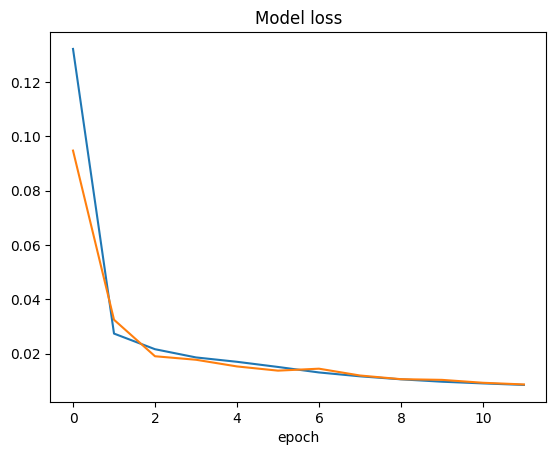

In [22]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('epoch')
plt.show()

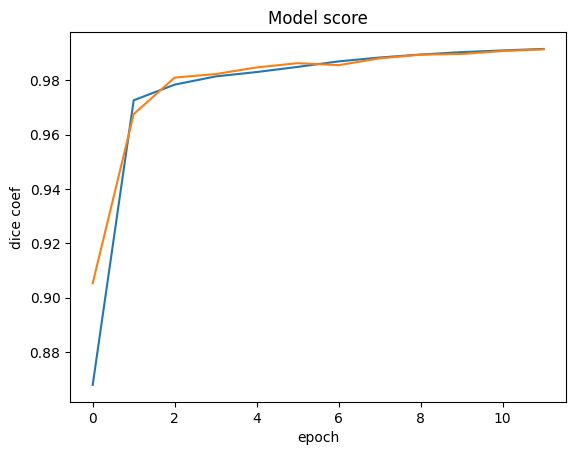

In [23]:
plt.plot(model_history.history['dice_coef'])
plt.plot(model_history.history['val_dice_coef'])
plt.title('Model score')
plt.ylabel('dice coef')
plt.xlabel('epoch')
plt.show()

In [24]:
Y_test_encoded = to_categorical(Y_test)

In [25]:
model.evaluate(X_test, Y_test_encoded)

99/99 [==============================] - 5s 52ms/step - loss: 0.0087 - dice_coef: 0.9913


[0.008714794181287289, 0.9912853837013245]

In [26]:
model.save('/content/drive/MyDrive/hgg_model.h5',overwrite=True)

**Loading Model**

In [27]:
from keras.models import load_model
loaded_model = load_model('/content/drive/MyDrive/hgg_model.h5', compile=False)


In [28]:
prediction1  = loaded_model.predict(X_test)
result1 = np.argmax(prediction1, axis=-1)
# print('Prediction result', result1)

99/99 [==============================] - 5s 43ms/step


In [29]:
np.unique(result1)

array([0, 1, 2, 3])

In [30]:
Y_pre=result1.reshape(-1,192,192,1)

X_test 450


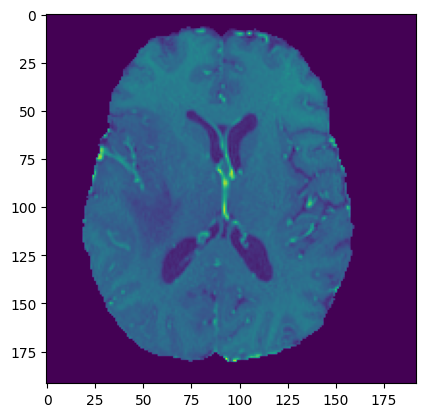

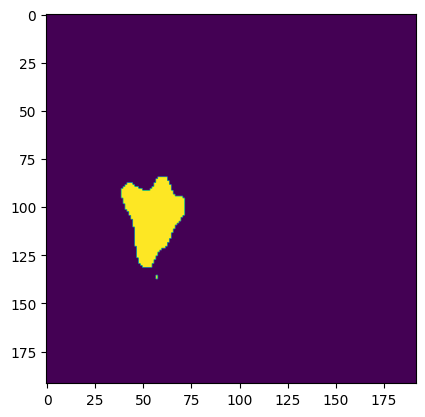

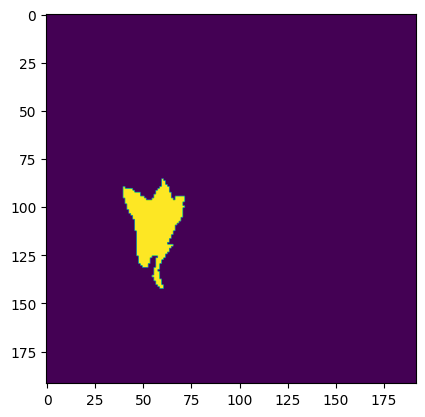

X_test 451


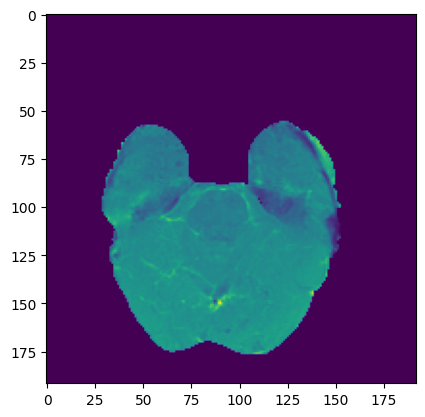

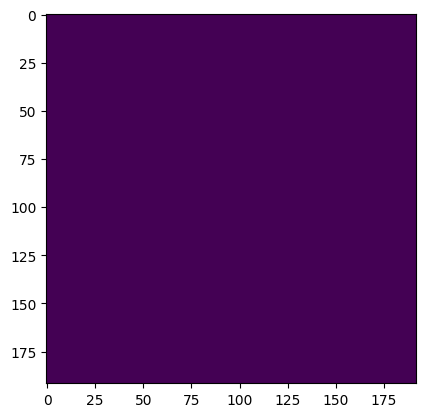

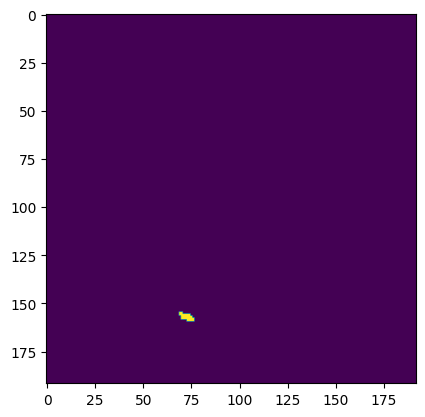

X_test 452


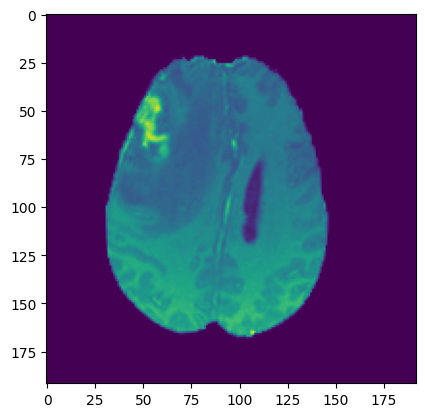

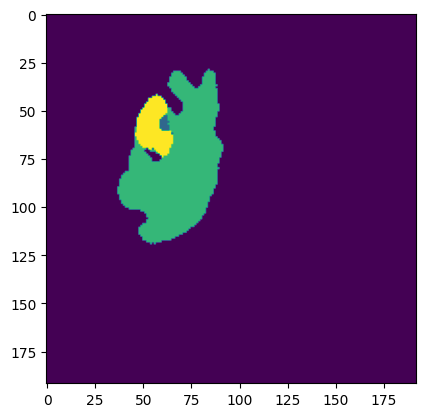

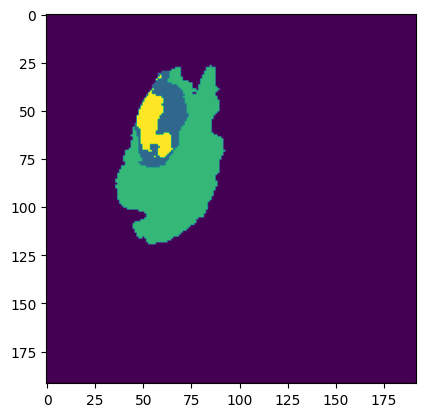

X_test 453


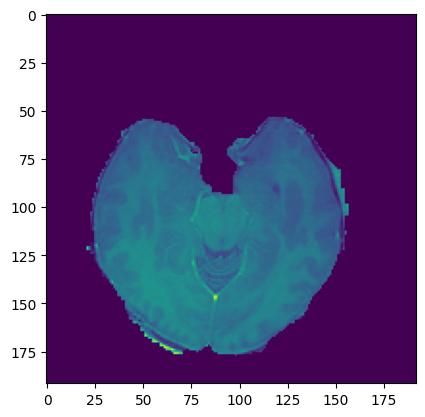

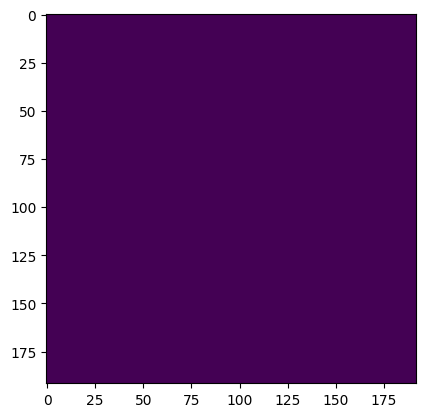

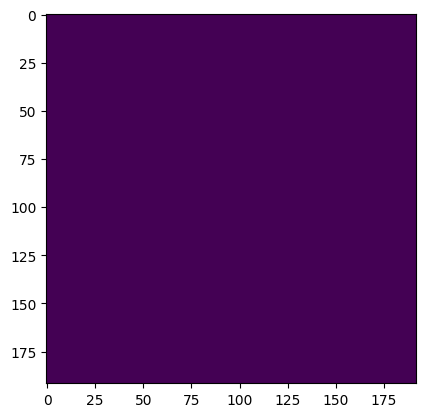

X_test 454


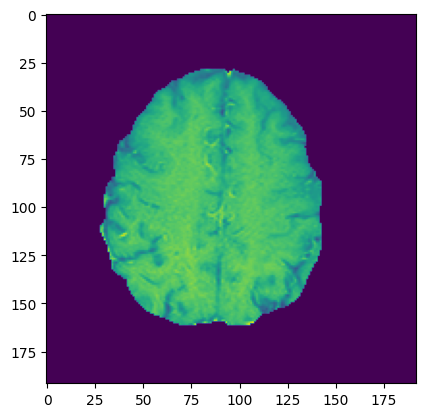

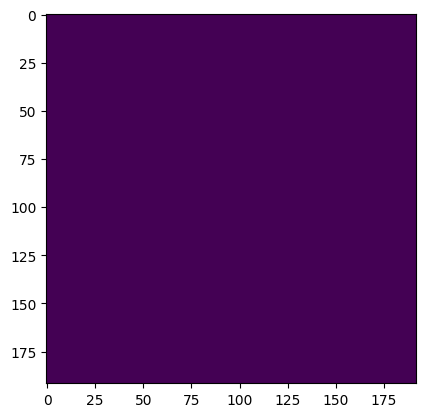

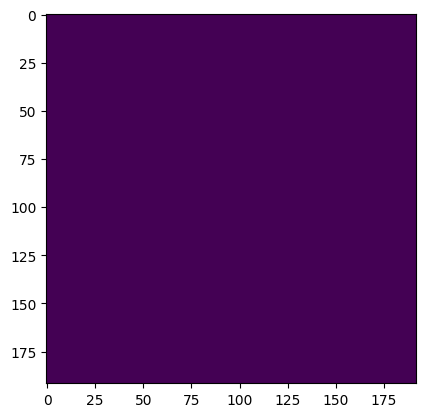

X_test 455


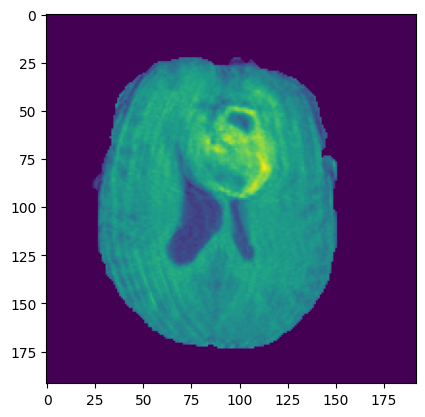

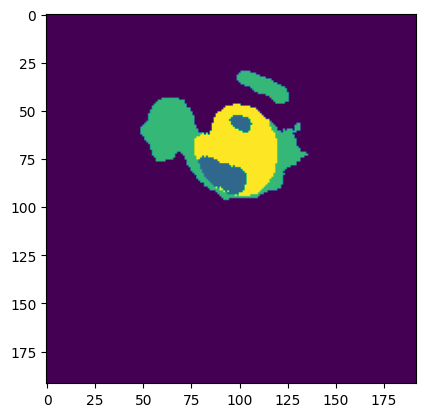

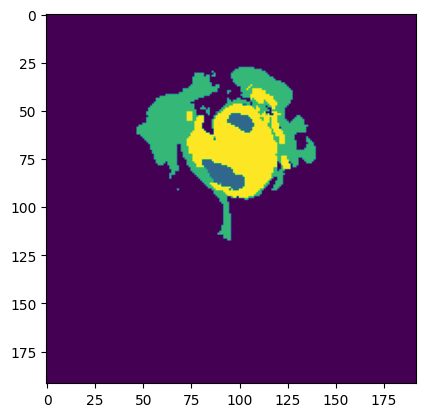

X_test 456


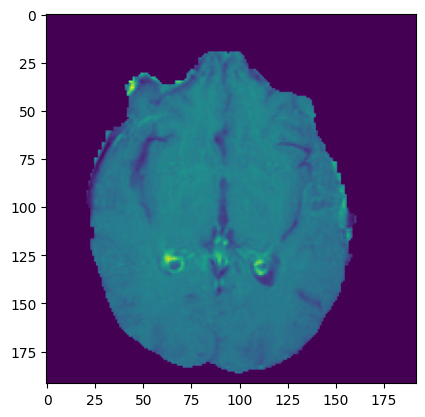

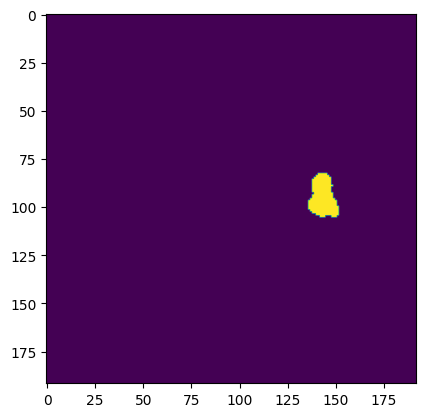

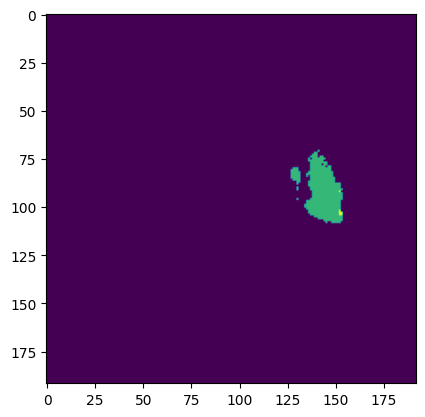

X_test 457


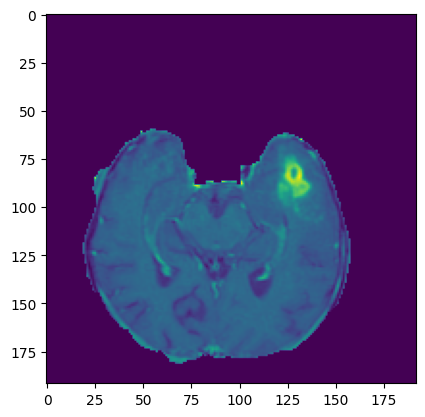

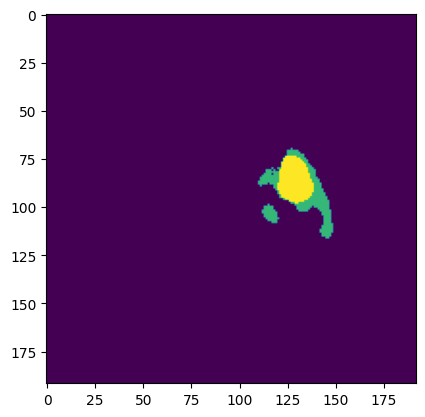

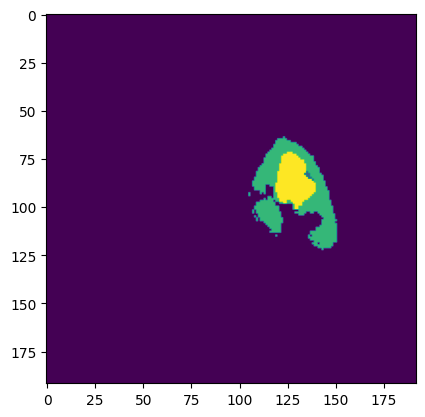

X_test 458


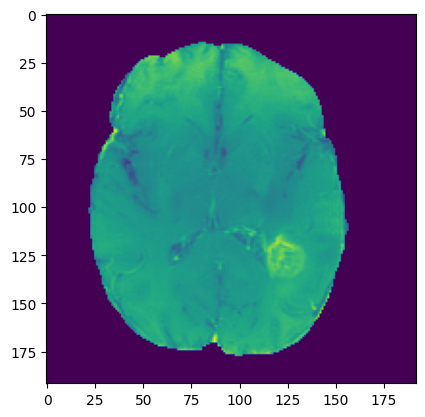

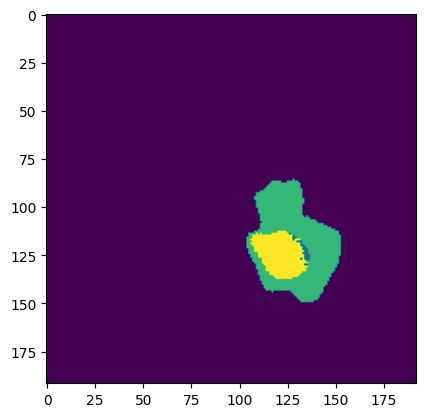

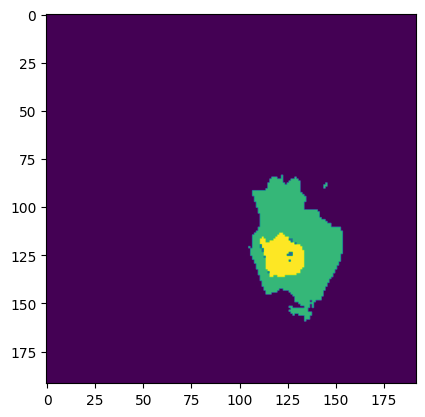

X_test 459


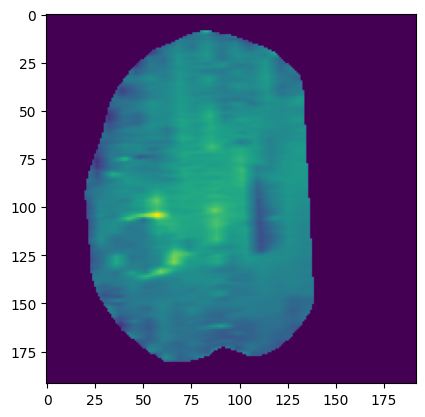

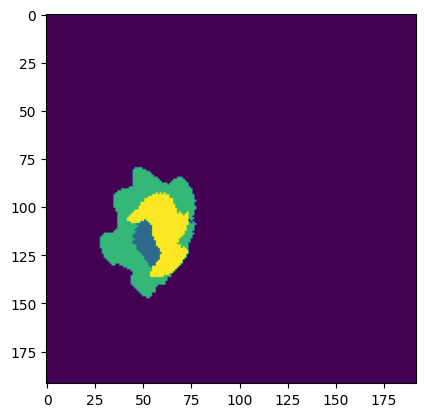

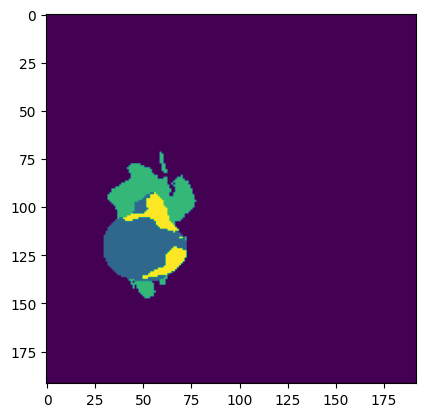

X_test 460


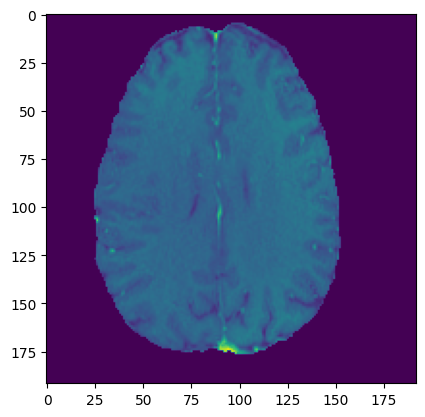

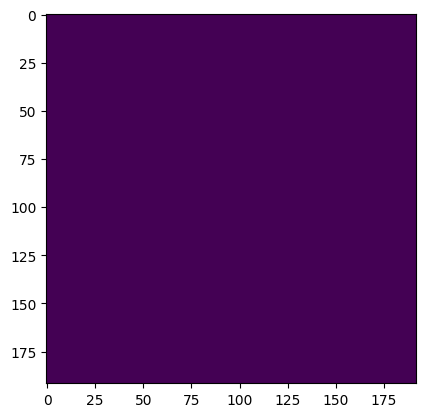

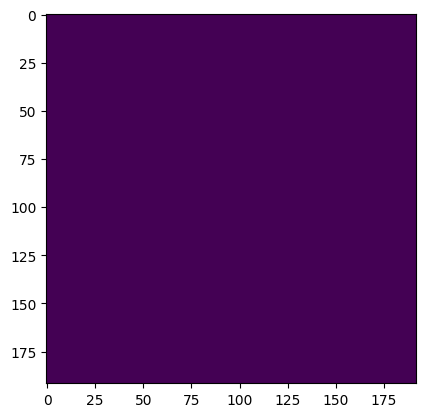

X_test 461


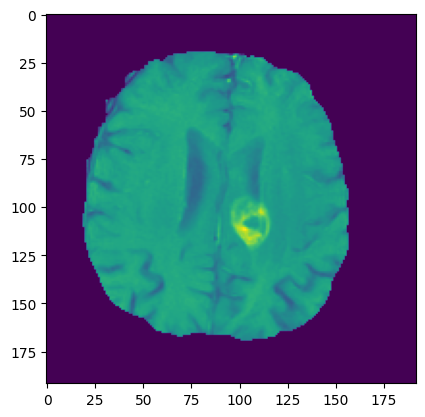

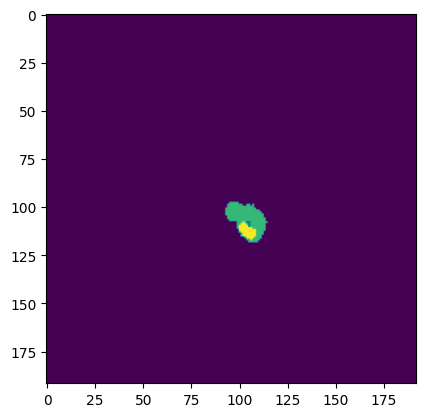

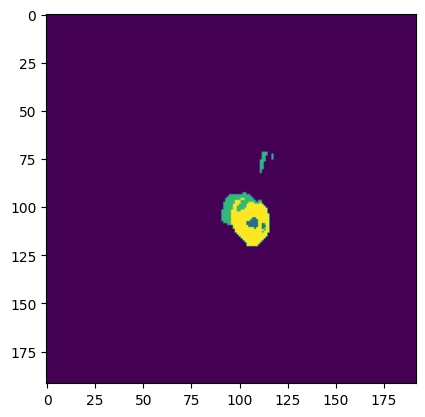

X_test 462


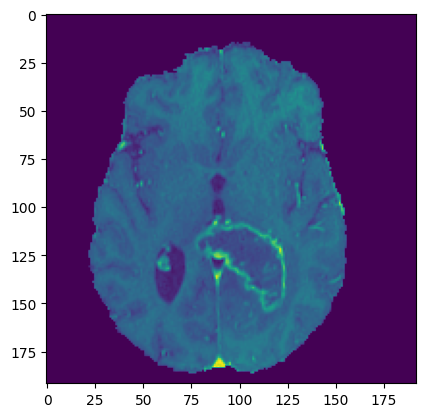

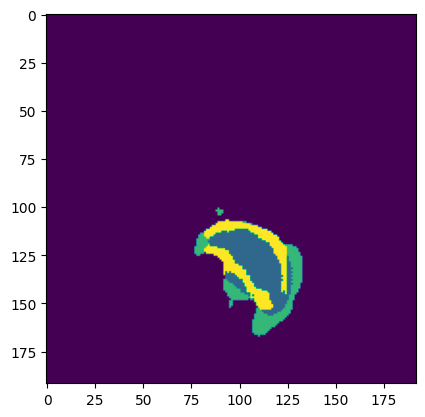

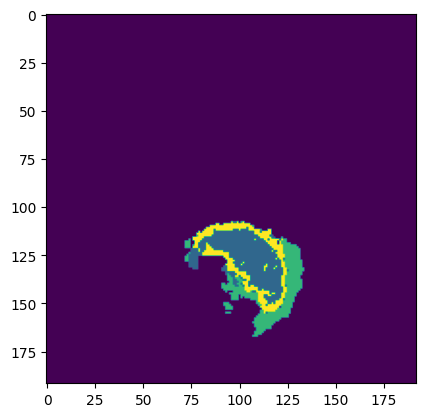

X_test 463


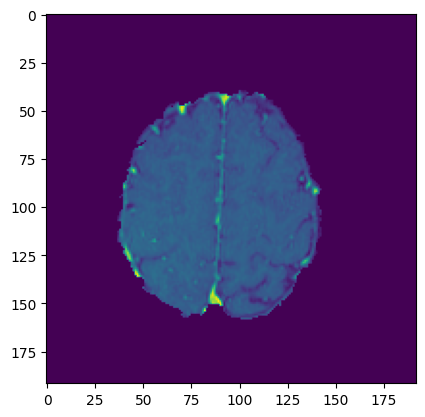

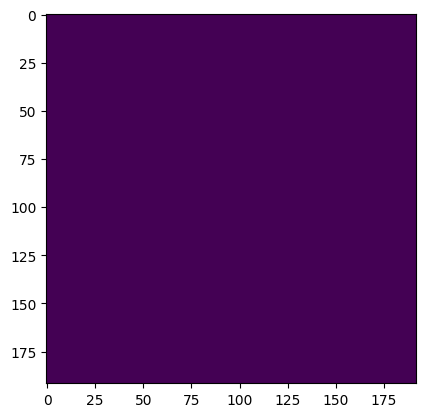

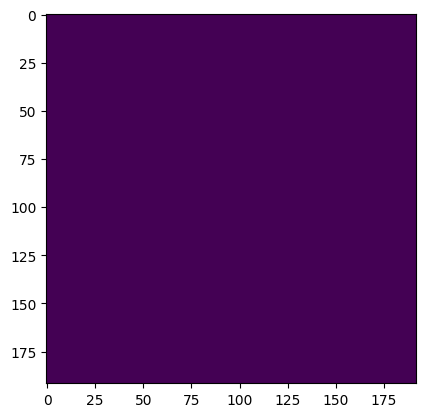

X_test 464


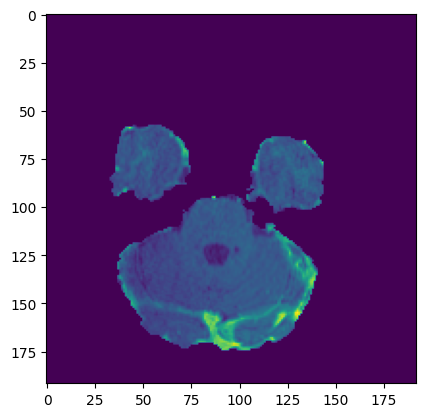

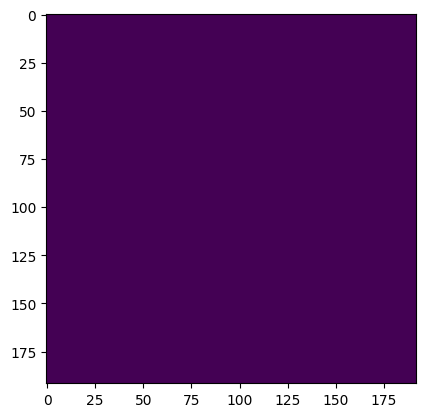

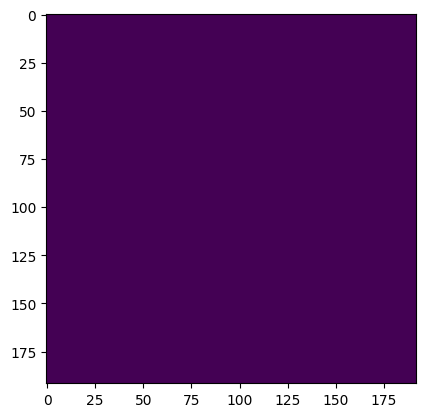

X_test 465


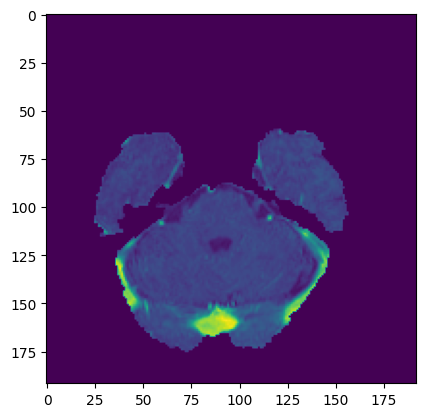

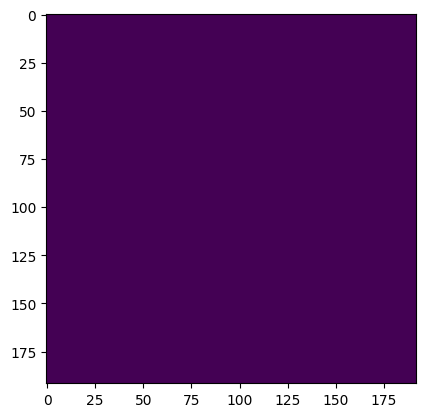

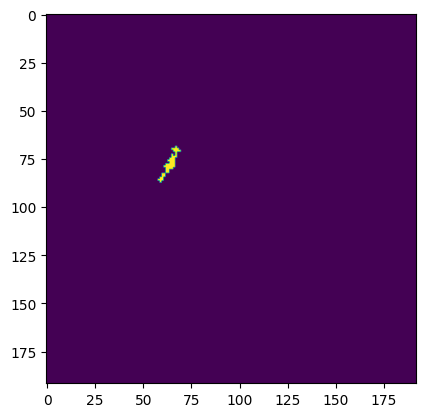

X_test 466


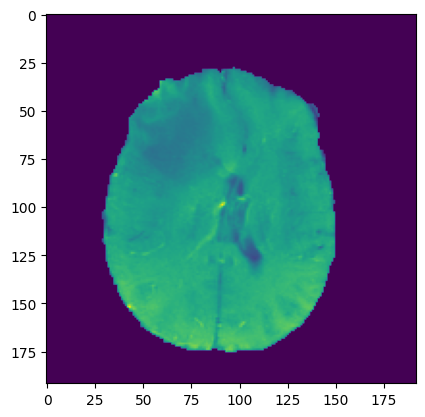

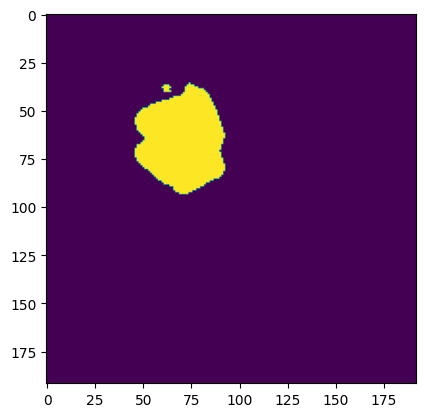

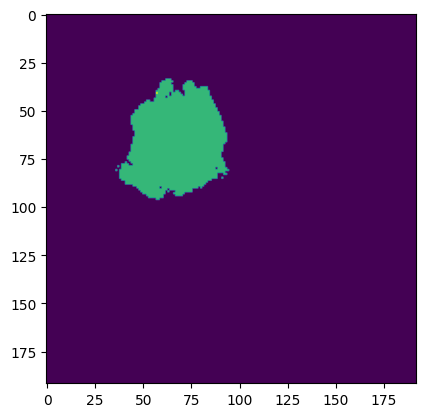

X_test 467


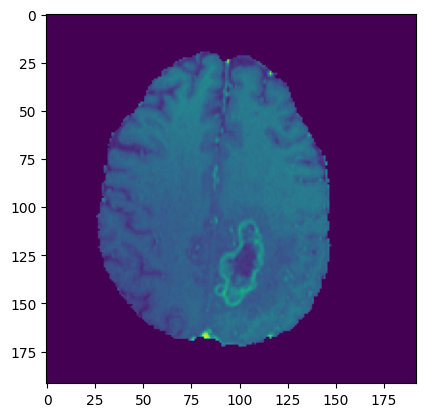

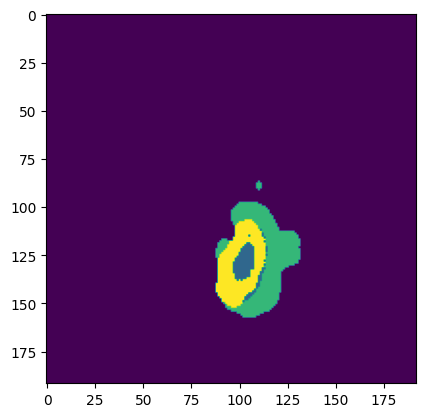

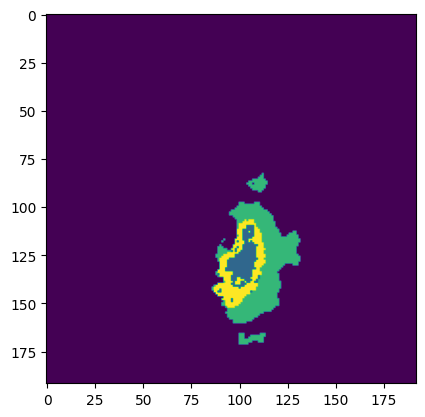

X_test 468


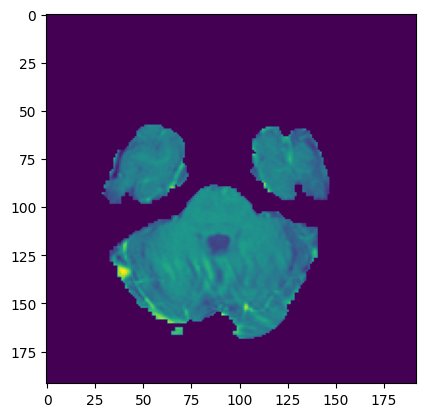

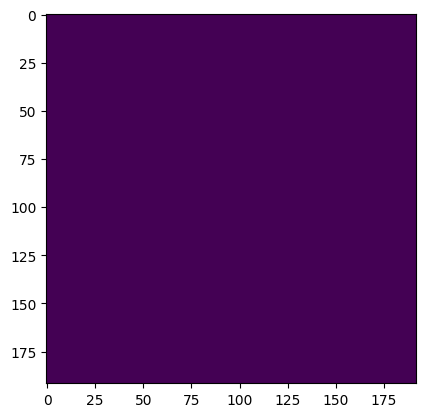

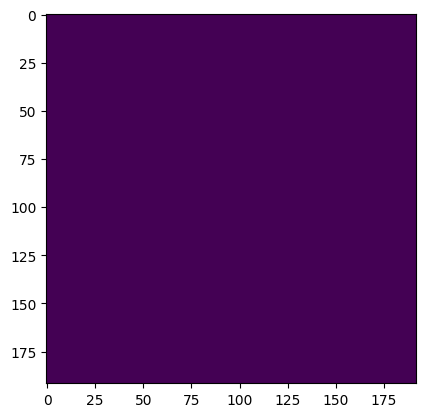

X_test 469


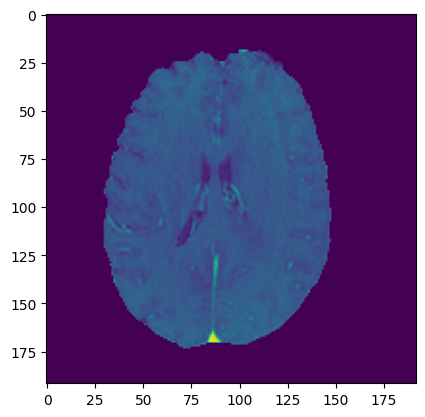

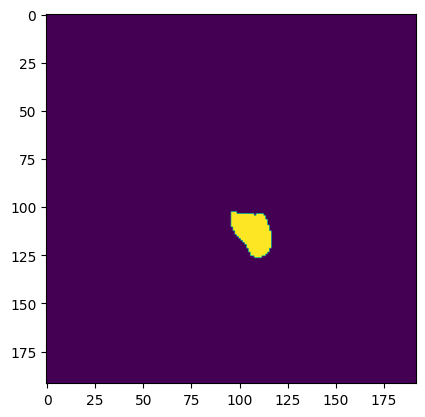

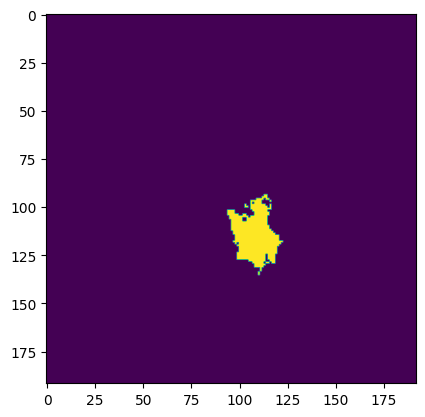

X_test 470


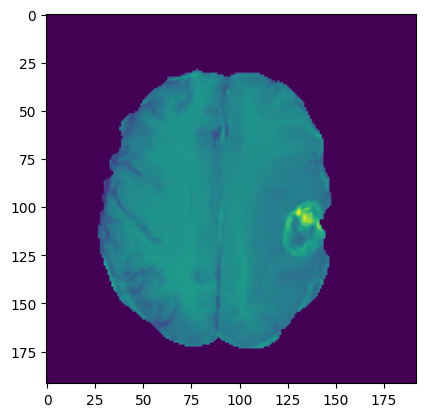

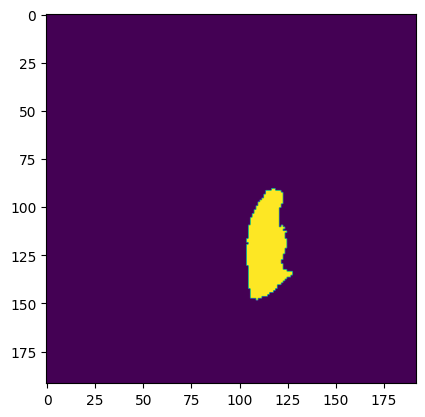

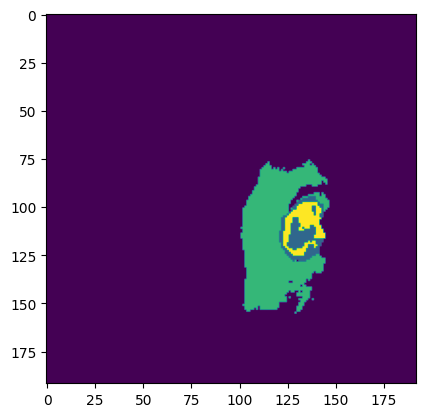

X_test 471


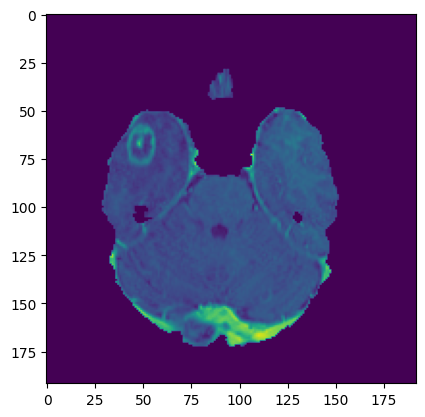

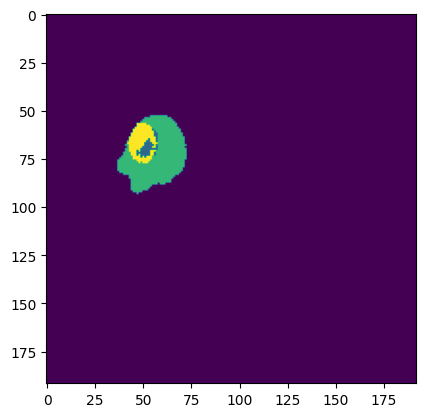

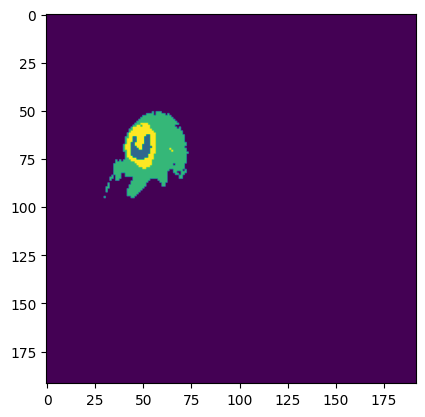

X_test 472


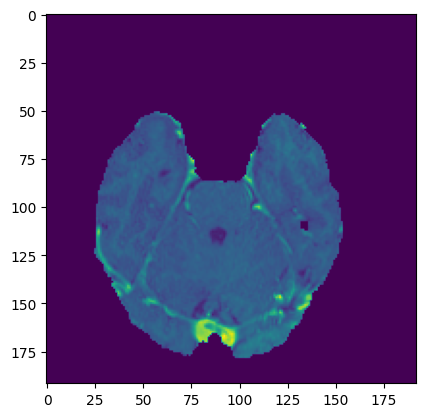

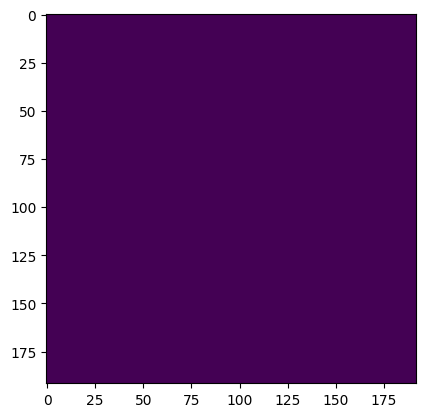

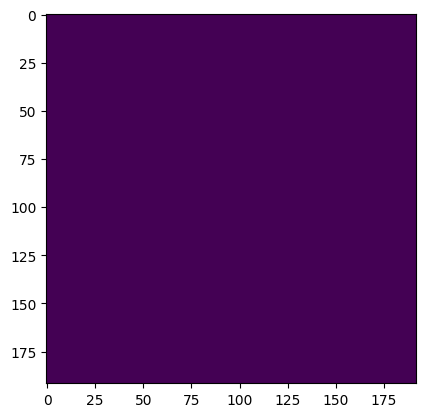

X_test 473


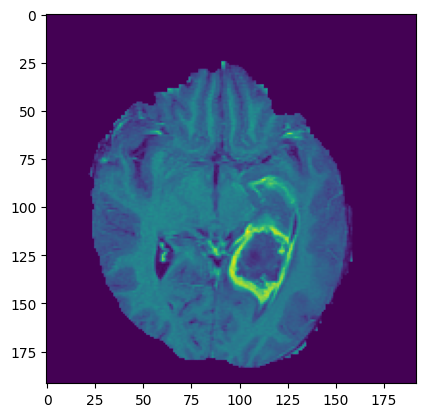

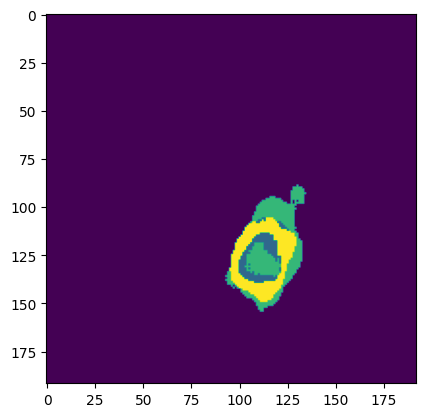

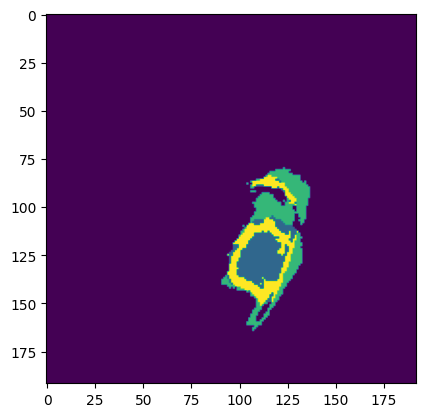

X_test 474


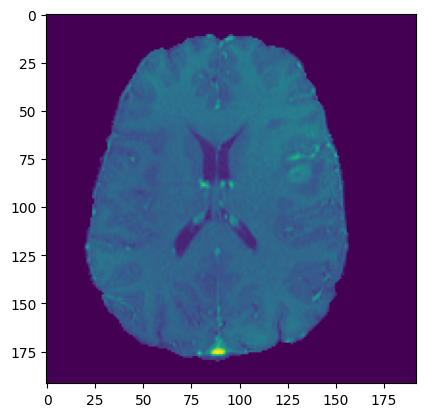

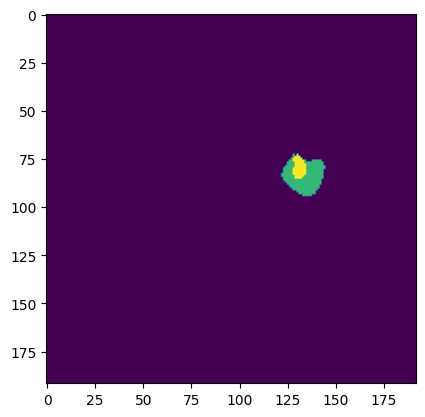

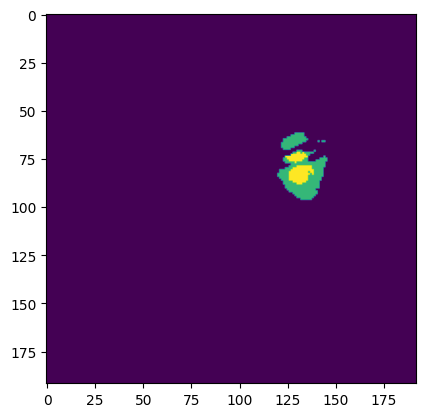

X_test 475


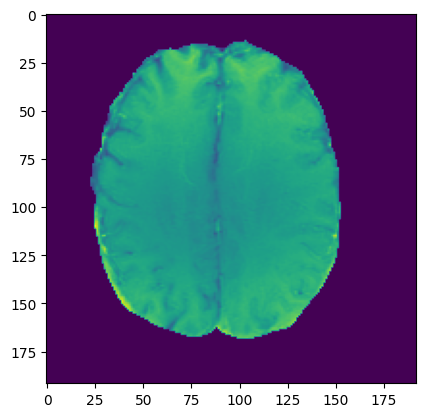

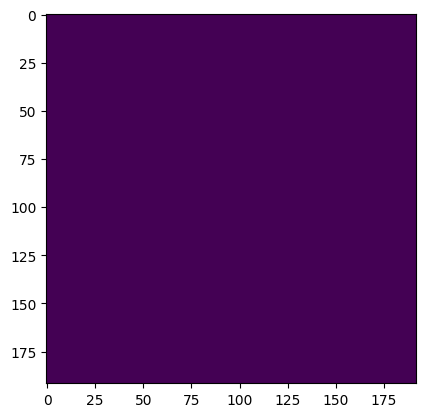

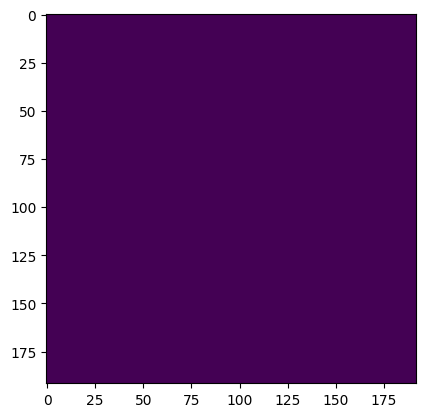

X_test 476


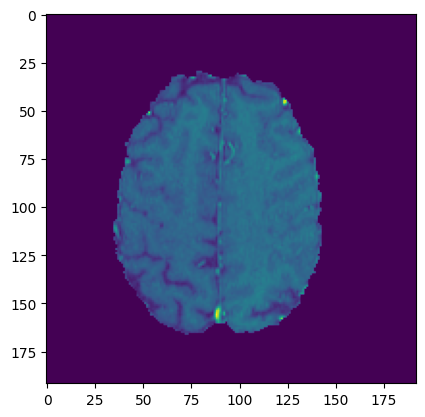

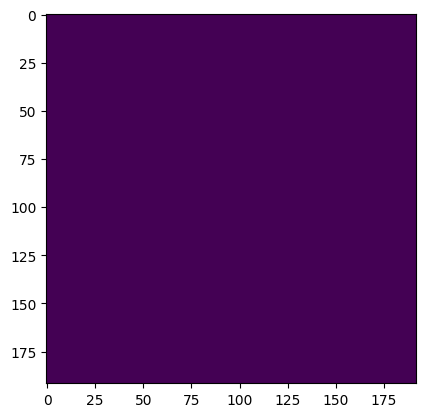

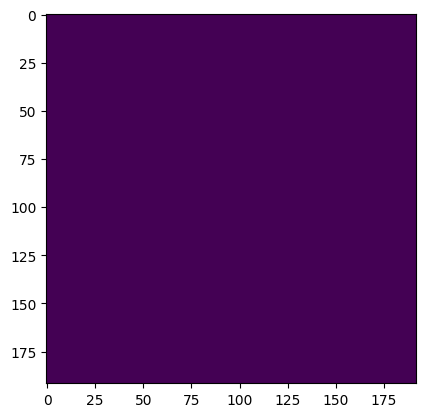

X_test 477


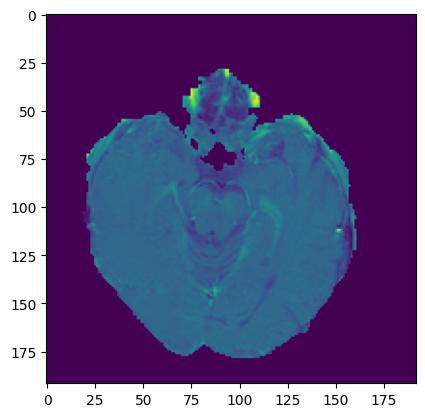

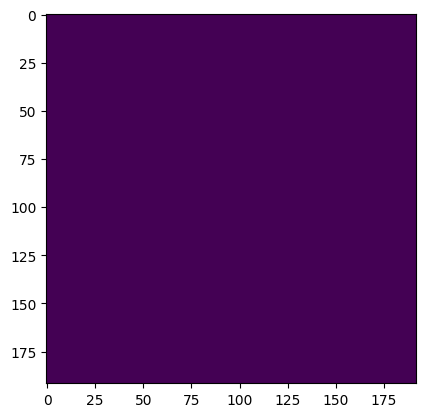

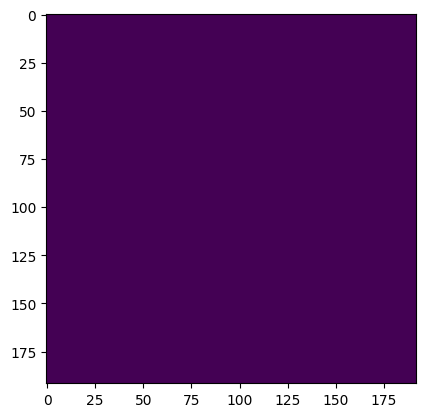

X_test 478


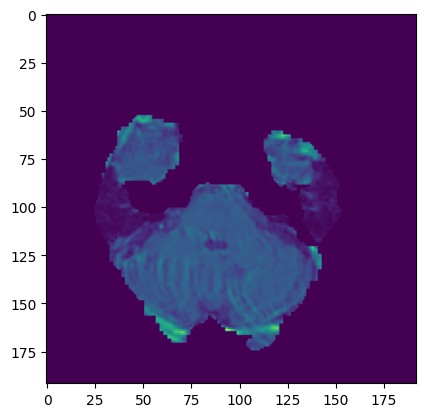

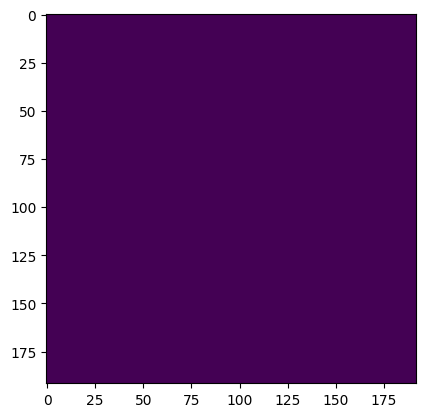

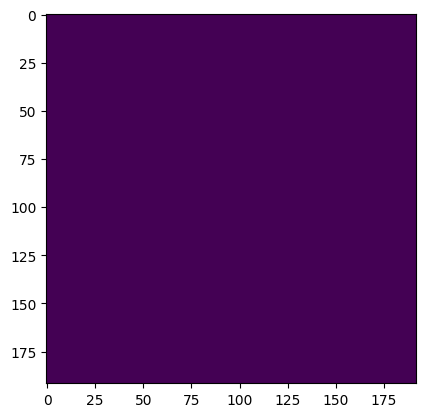

X_test 479


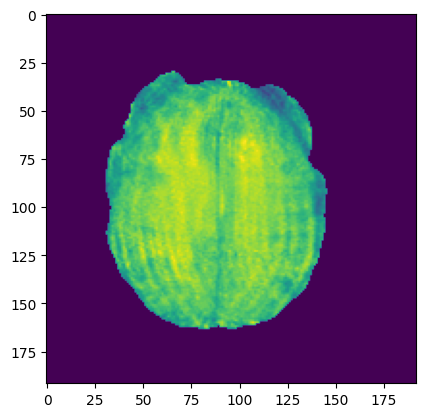

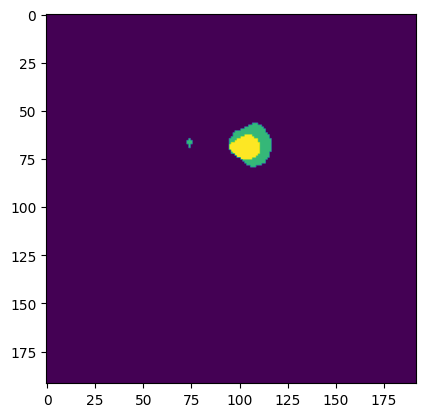

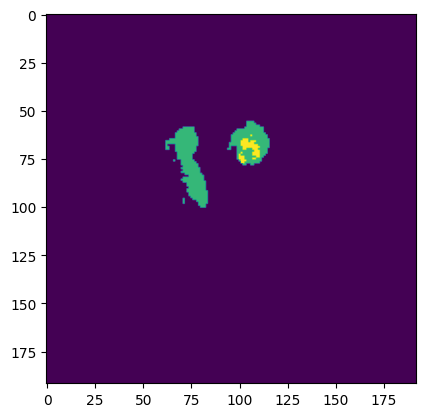

X_test 480


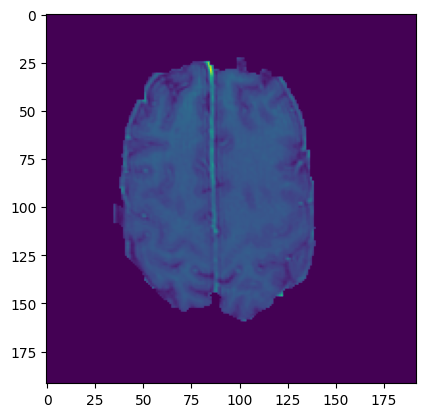

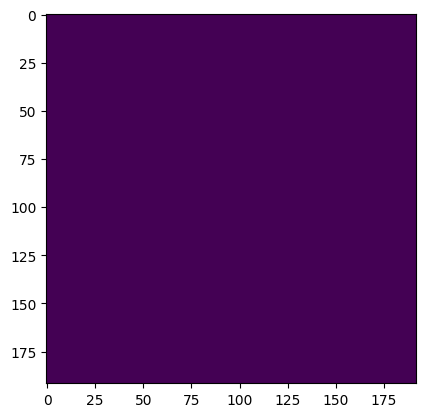

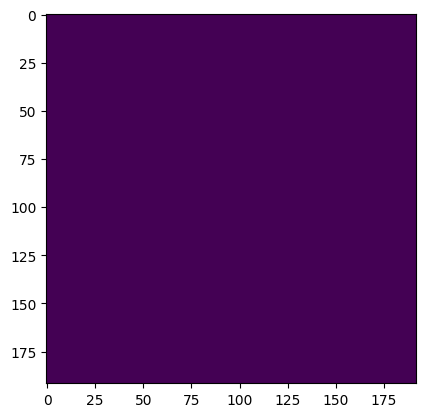

X_test 481


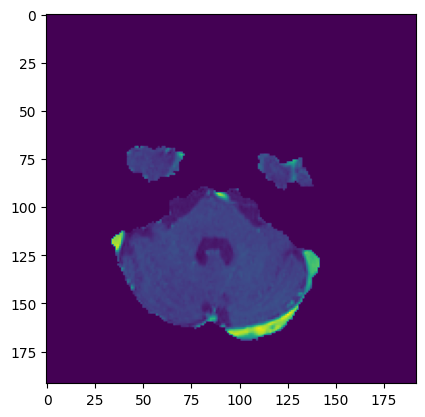

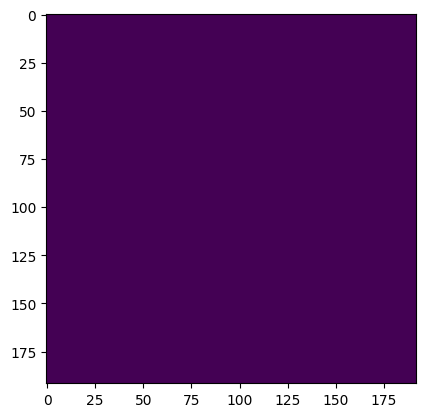

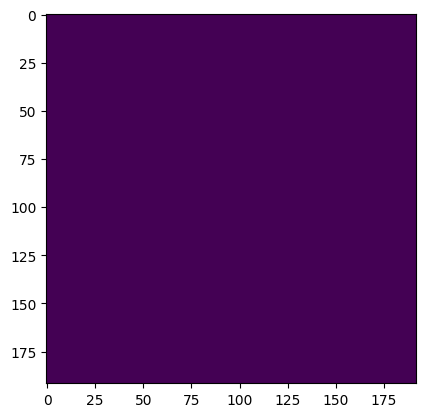

X_test 482


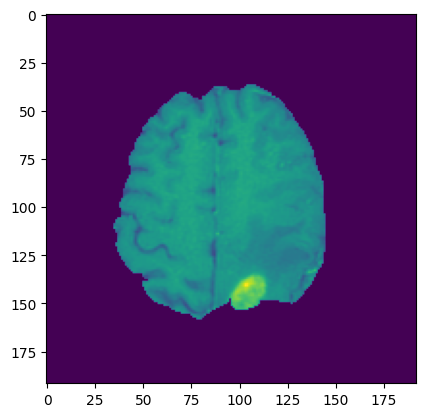

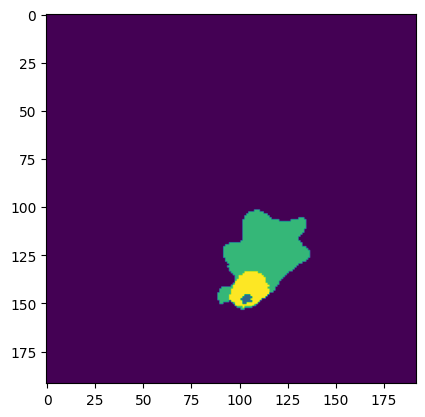

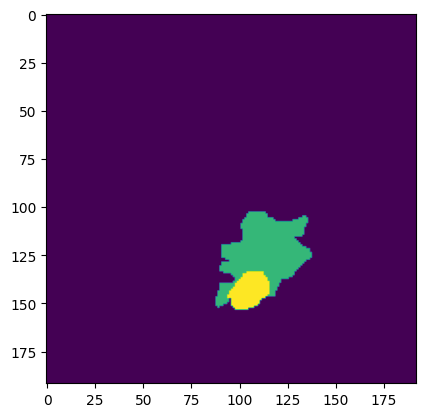

X_test 483


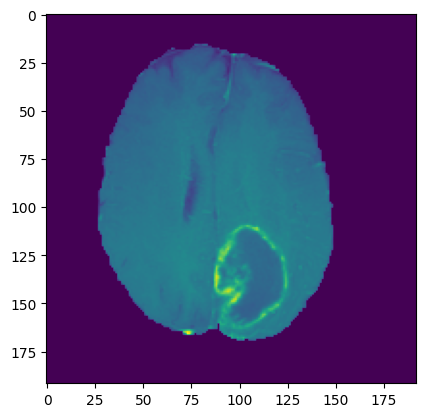

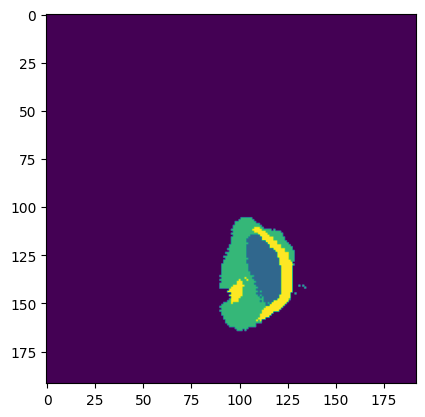

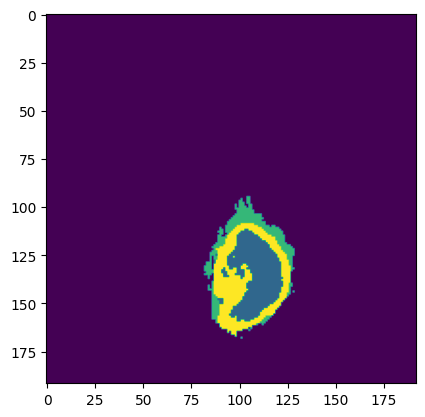

X_test 484


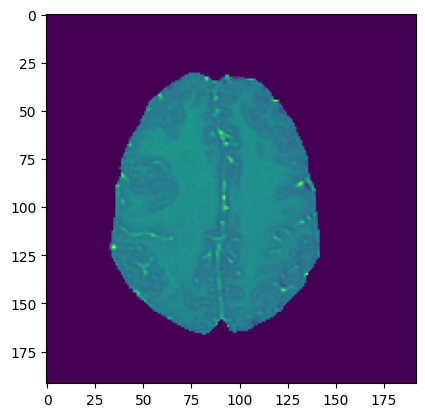

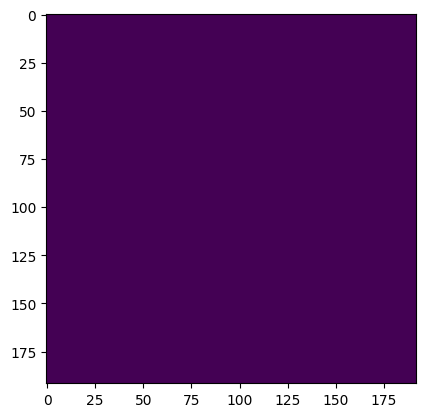

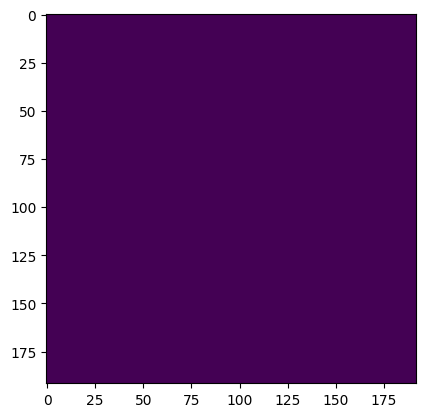

X_test 485


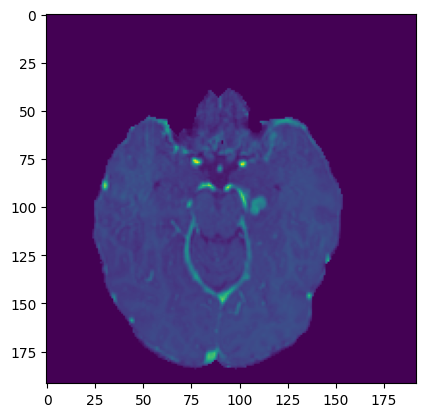

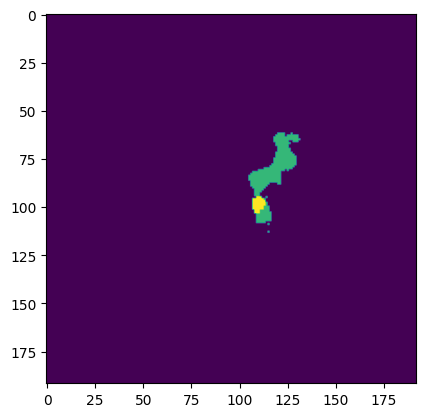

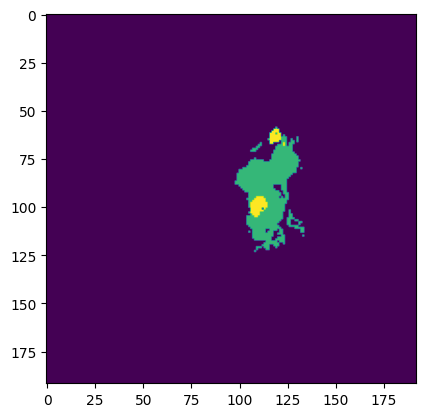

X_test 486


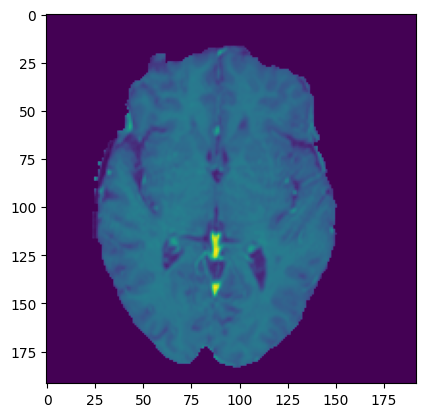

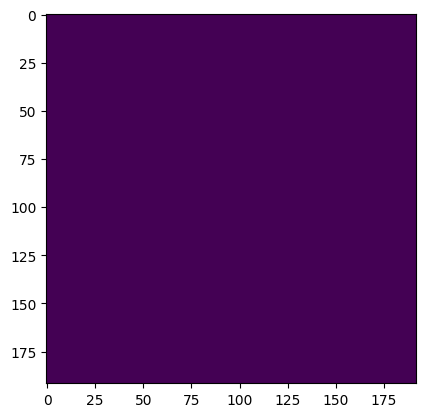

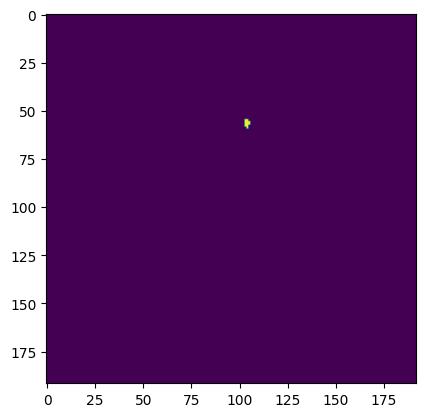

X_test 487


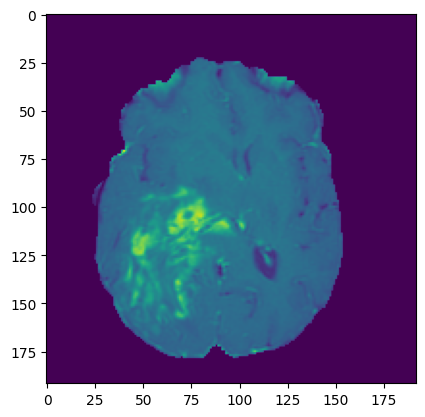

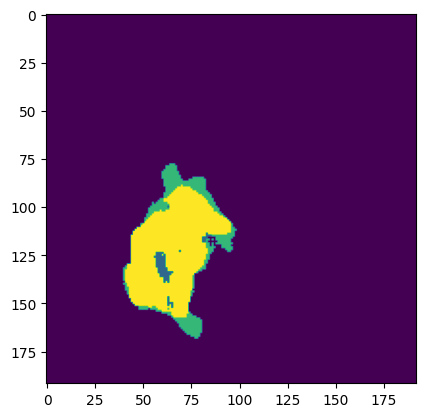

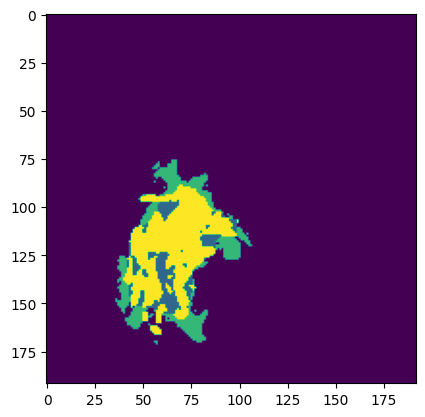

X_test 488


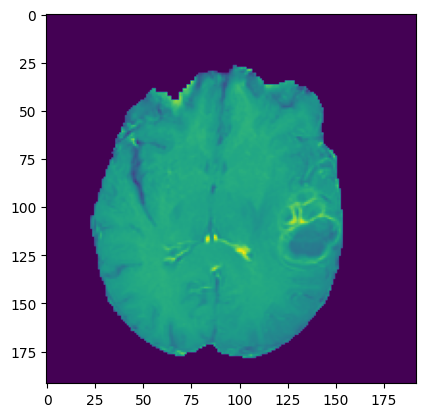

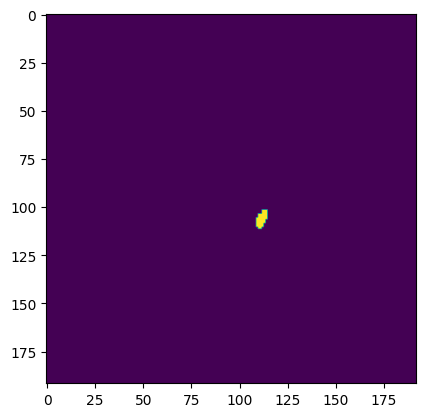

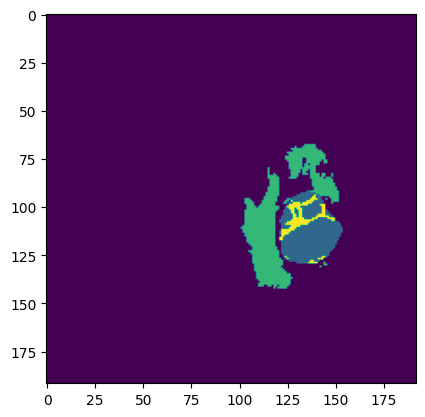

X_test 489


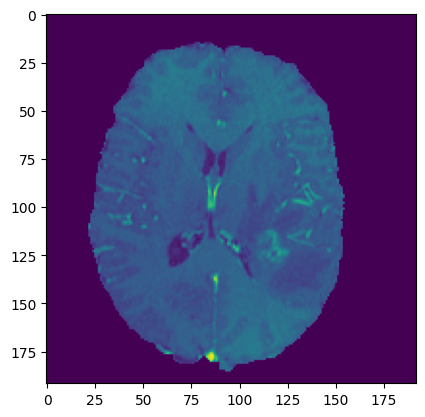

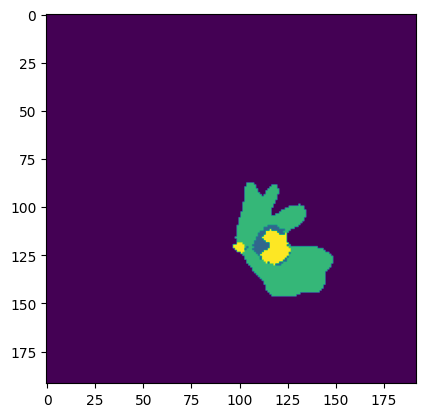

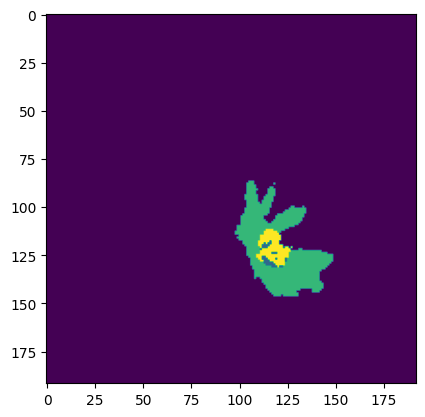

X_test 490


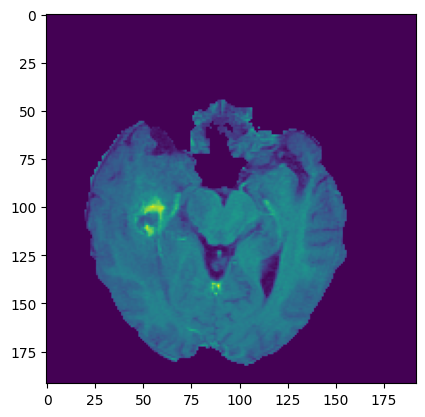

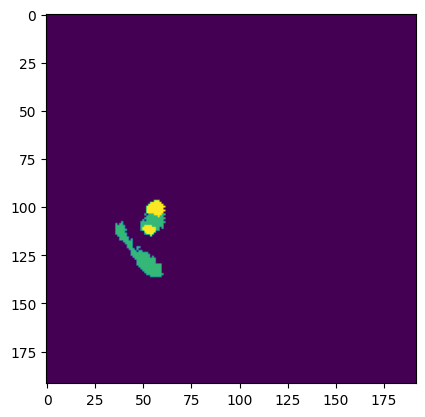

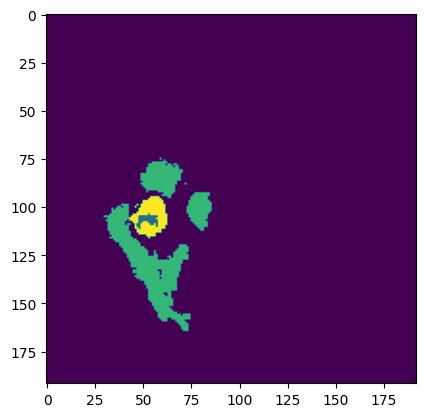

X_test 491


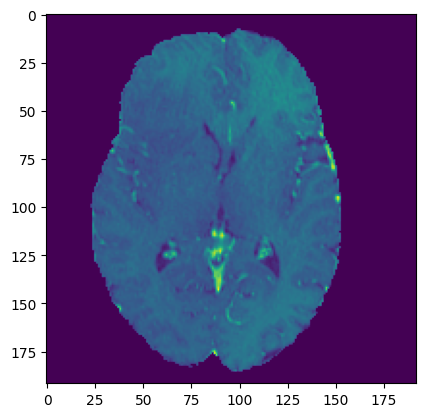

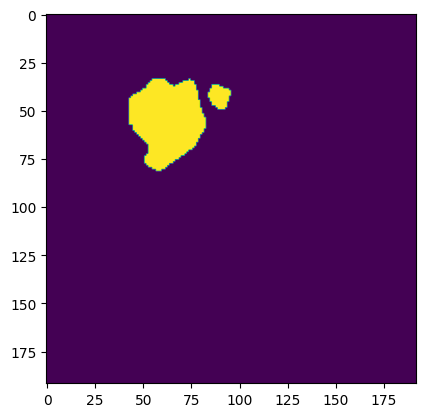

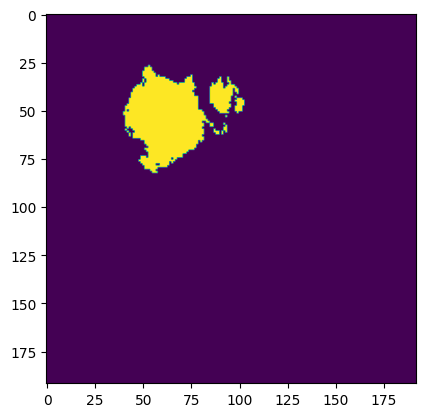

X_test 492


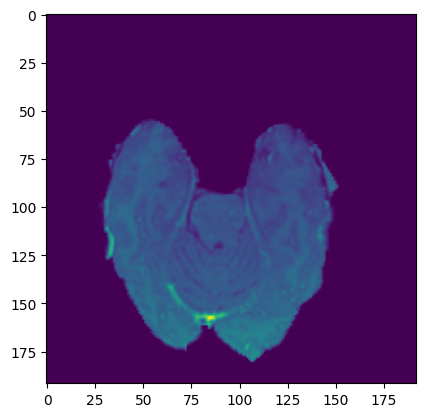

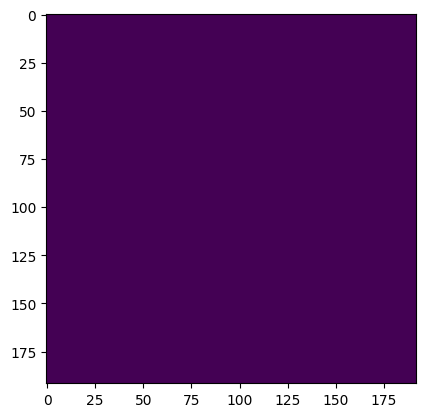

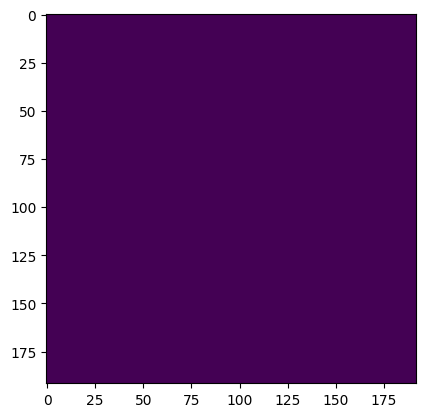

X_test 493


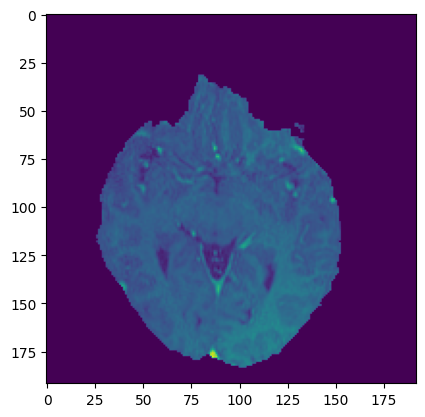

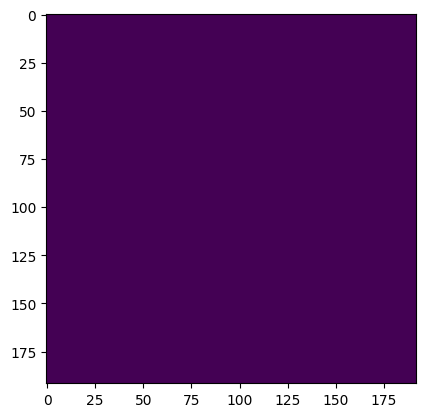

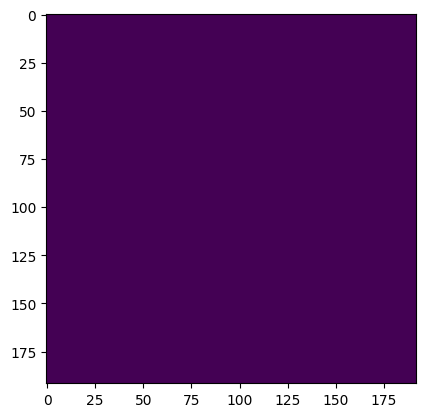

X_test 494


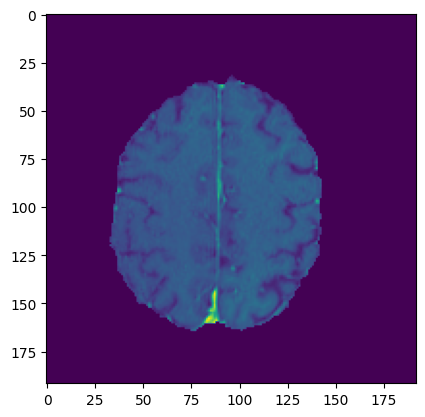

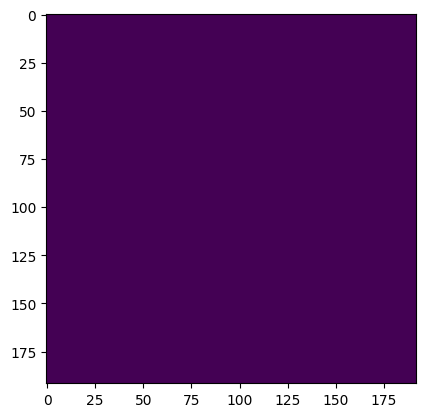

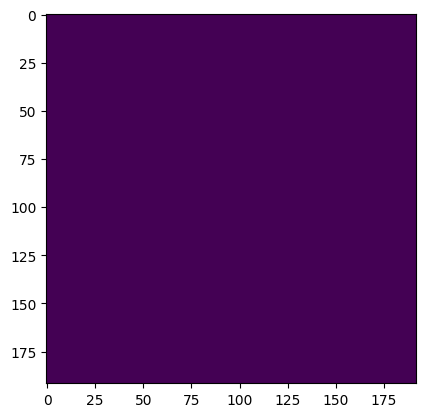

X_test 495


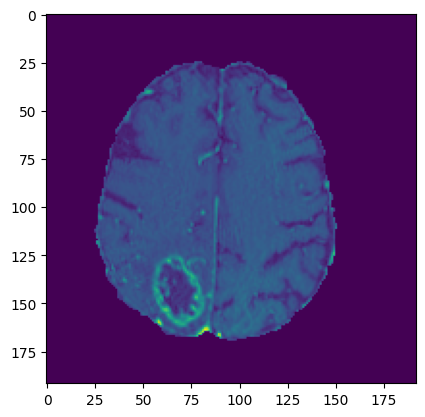

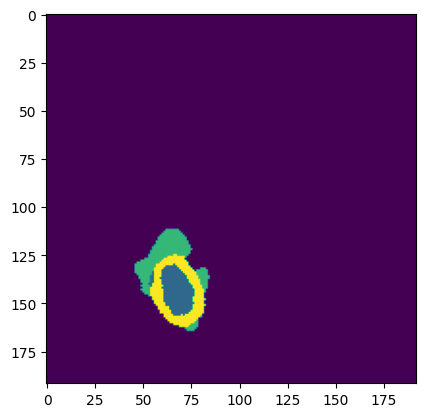

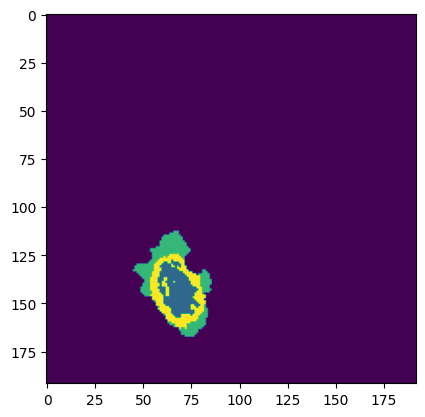

X_test 496


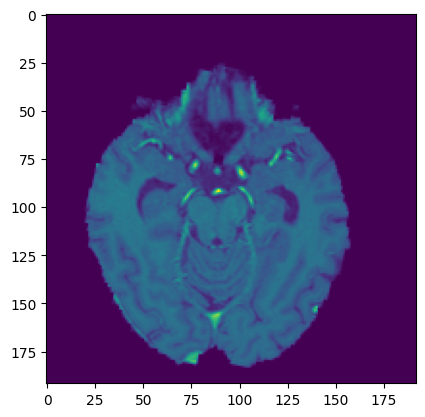

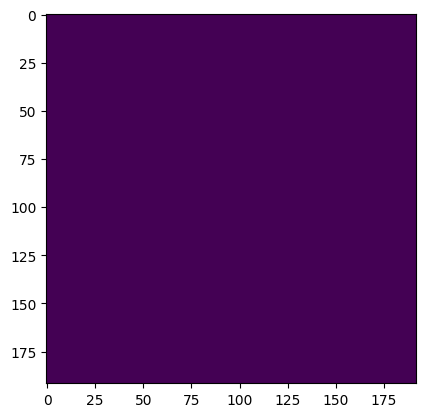

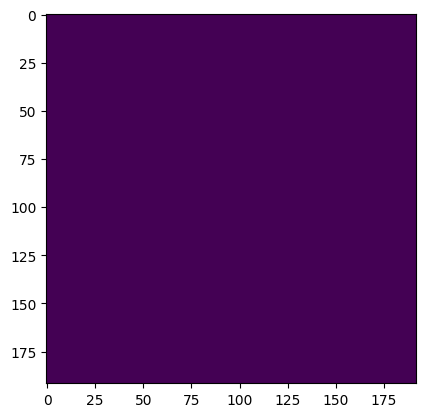

X_test 497


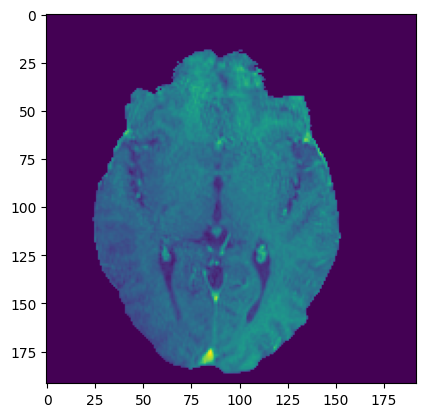

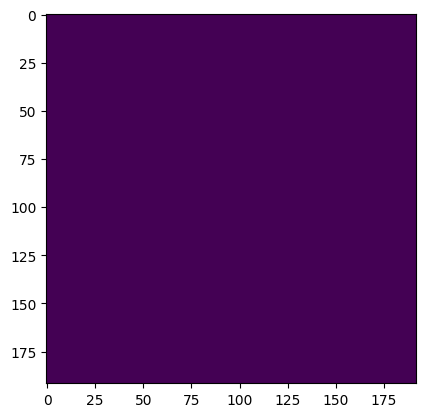

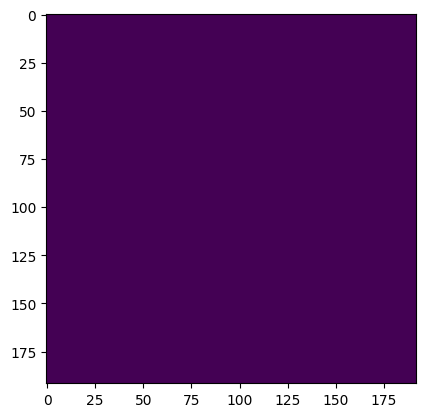

X_test 498


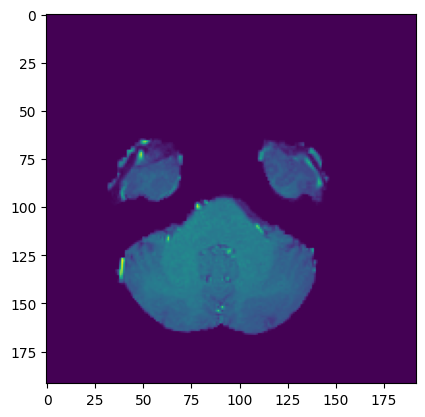

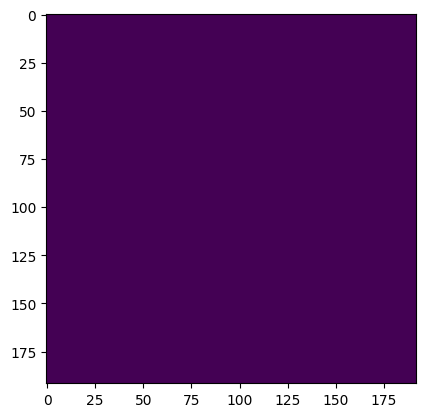

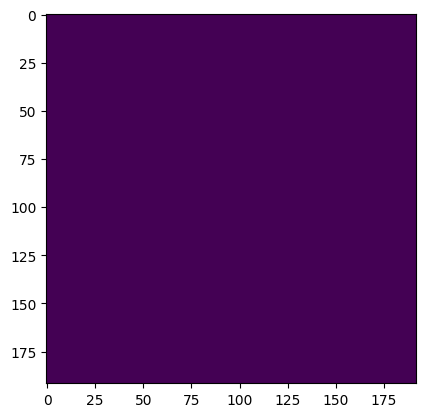

X_test 499


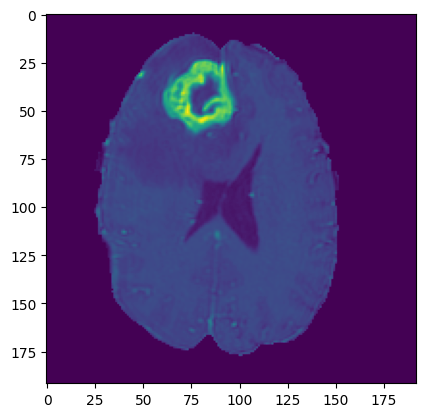

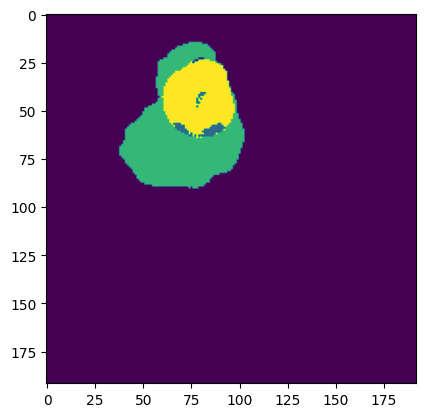

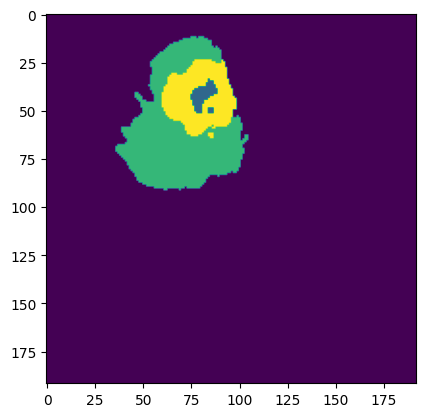

In [31]:
for i in range(450,500):
  print('X_test '+ str(i))
  plt.imshow(X_test[i,:,:,2])
  plt.show()
  plt.imshow(Y_pre[i,:,:,0])
  plt.show()
  plt.imshow(Y_test[i,:,:,0])
  plt.show()